# Data 102 Project

# Imports

In [1]:
!pip install scikit-learn
!pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats

# Data Overview

## Data Sources:

### PM 2.5 Concentrations Dataset

### Ozone Concentrations Dataset

### Cardiovascular Disease Dataset

### Asthma Dataset

### FIPS Reference

## Reference Material:

### CDC Indicators for Chronic Disease Surveillance U.S.

## Data Cleaning

### Aggregating Large Datasets

Both pm2.5 concentrations and ozone concentrations had over 100 million rows. Most notebooks cannot handle files of this size so we decided to aggregate the data by state's monthly concentration averages. Here is the Python script that we used:

In [3]:
# aggregate_monthly_average.py
import argparse
from tqdm import tqdm

def aggregate_monthly_average(input_file, output_file, value_column):
    data = pd.read_csv(input_file, iterator=True, chunksize=10000)

    aggregated_data = pd.DataFrame()

    for chunk in tqdm(data, desc='Processing', unit='chunk'):
        chunk['date'] = pd.to_datetime(chunk['date'], format='%d%b%Y')
        chunk['year'] = chunk['date'].dt.year
        chunk['month'] = chunk['date'].dt.month
        monthly_average = chunk.groupby(['statefips', 'year', 'month'])[value_column].mean().reset_index()

        aggregated_data = aggregated_data.append(monthly_average, ignore_index=True)

    final_monthly_average = aggregated_data.groupby(['statefips', 'year', 'month'])[value_column].mean().reset_index()

    final_monthly_average.to_csv(output_file, index=False)

# if __name__ == '__main__':
#     parser = argparse.ArgumentParser(description='Aggregate monthly averages of a specified value column.')
#     parser.add_argument('input_file', type=str, help='Input CSV file containing the dataset.')
#     parser.add_argument('output_file', type=str, help='Output CSV file for the aggregated data.')
#     parser.add_argument('value_column', type=str, help='Name of the column containing the values to aggregate.')

#     args = parser.parse_args()

#     aggregate_monthly_average(args.input_file, args.output_file, args.value_column)

### Loading Files to Dataframes

In [4]:
pm25 = pd.read_csv('pm25_concentrations_monthly_average_state.csv')
ozone = pd.read_csv('ozone_concentrations_monthly_average_states.csv')
asthma = pd.read_csv('asthma.csv')
cardio = pd.read_csv('cvd.csv')
fips = pd.read_csv('us-state-ansi-fips.csv')

# EDA

## FIPS Code Reference for U.S. States

### Columns

STATE_NAME -> state name

STATE -> state code

STUSAB -> state abbreviation

### Dataframe

In [5]:
from io import StringIO
from urllib.request import urlopen

url = 'https://www2.census.gov/geo/docs/reference/state.txt'

# Open the URL and read the content
with urlopen(url) as response:
    data = response.read().decode()


fips_ref = pd.read_csv(StringIO(data), sep='|')
fips_ref.drop('STATENS',axis=1, inplace=True)
fips_ref.head()

,STATE,STUSAB,STATE_NAME
0,1,AL,Alabama
1,2,AK,Alaska
2,4,AZ,Arizona
3,5,AR,Arkansas
4,6,CA,California


------

## Particulate Matter 2.5 Concentrations State's Monthly Average

### Columns

statefips -> Federal Information Processing System (FIPS) Codes for States. FIPS codes are numbers that uniquely identify states.

year -> Year of estimate

month -> Month of estimate

pm_average -> The monthly average prediction of a state's pm 2.5 concentration 

### Dataframe

In [6]:
pm25.rename(columns={'ds_pm_pred': 'pm_avg'}, inplace=True)
pm25.head()

,statefips,year,month,pm_avg
0,1,2011,1,9.975820
1,1,2011,2,10.970784
2,1,2011,3,10.809733
3,1,2011,4,8.937865
4,1,2011,5,11.590264


How many states does the pm25 dataset represent?

In [7]:
len(pm25["statefips"].unique())

49

What unique states are represented in the pm25 dataset?

In [8]:

pm25_states = pm25["statefips"].unique()
pm25_states

array([ 1,  4,  5,  6,  8,  9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56])

What states are not represented in the pm25 dataset?


In [9]:
def missing_states_abbr(input_fips):
    # Filter the reference DataFrame to find rows with FIPS codes not in input_fips
    missing_states = fips_ref[~fips_ref['STATE'].isin(input_fips)]

    # Return the abbreviations of the missing states as a list
    missing_abbr = missing_states['STATE_NAME'].tolist()

    return missing_abbr

missing_states_abbr(pm25_states)

['Alaska',
 'Hawaii',
 'American Samoa',
 'Guam',
 'Northern Mariana Islands',
 'Puerto Rico',
 'U.S. Minor Outlying Islands',
 'U.S. Virgin Islands']

Lets double check that every state has a monthly value for all four years of pm 2.5 concentrations

In [10]:
# Count the number of months with data for each state and year
monthly_count = pm25.groupby(['statefips', 'year']).agg({'month': 'count'}).reset_index()

# Reshape the data for easier visualization
monthly_count_pivot = monthly_count.pivot_table(index='statefips', columns='year', values='month', fill_value=0)

# Display the result
print(monthly_count_pivot)
print('States counted: ' + str(len(monthly_count_pivot)))

year       2011  2012  2013  2014
statefips                        
1            12    12    12    12
4            12    12    12    12
5            12    12    12    12
6            12    12    12    12
8            12    12    12    12
9            12    12    12    12
10           12    12    12    12
11           12    12    12    12
12           12    12    12    12
13           12    12    12    12
16           12    12    12    12
17           12    12    12    12
18           12    12    12    12
19           12    12    12    12
20           12    12    12    12
21           12    12    12    12
22           12    12    12    12
23           12    12    12    12
24           12    12    12    12
25           12    12    12    12
26           12    12    12    12
27           12    12    12    12
28           12    12    12    12
29           12    12    12    12
30           12    12    12    12
31           12    12    12    12
32           12    12    12    12
33           1

What are the yearly averages of each state's pm2.5 concentrations?

In [11]:
yearly_pm25_avg = pm25.groupby(['statefips', 'year']).agg({'pm_avg': 'mean'}).reset_index()
yearly_pm25_avg

,statefips,year,pm_avg
0,1,2011,10.697373
1,1,2012,10.262196
2,1,2013,9.914189
3,1,2014,10.810407
4,4,2011,7.900381
...,...,...,...
191,55,2014,9.218036
192,56,2011,5.909060
193,56,2012,6.274367
194,56,2013,5.209208


Lets plot the distribution of average pm25 concentration by state to test if it's normally distributed

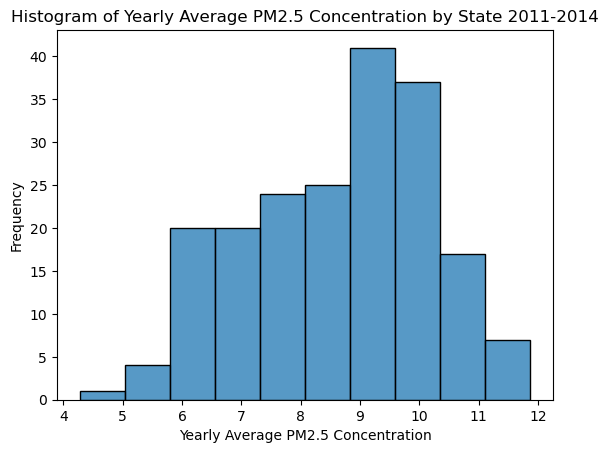

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=yearly_pm25_avg, x='pm_avg')

plt.xlabel('Yearly Average PM2.5 Concentration')
plt.ylabel('Frequency')
plt.title('Histogram of Yearly Average PM2.5 Concentration by State 2011-2014')

plt.show()


## Ozone Concentrations State's Monthly Average

In [13]:
ozone.rename(columns={'ds_o3_pred': 'o3_avg'}, inplace=True)
ozone.head()

,statefips,year,month,o3_avg
0,1,2011,1,34.037455
1,1,2011,2,39.167832
2,1,2011,3,41.406328
3,1,2011,4,43.477089
4,1,2011,5,44.941290


How many states does the ozone dataset represent?

In [14]:
len(ozone["statefips"].unique())

49

What unique states are represented in the ozone dataset?

In [15]:
ozone_states = ozone["statefips"].unique()
ozone_states

array([ 1,  4,  5,  6,  8,  9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56])

What states are not represented in the ozone dataset?


In [16]:
missing_states = missing_states_abbr(ozone_states)
missing_states

['Alaska',
 'Hawaii',
 'American Samoa',
 'Guam',
 'Northern Mariana Islands',
 'Puerto Rico',
 'U.S. Minor Outlying Islands',
 'U.S. Virgin Islands']

Lets double check that every state has a monthly value for all four years of ozone concentrations

In [17]:
# Count the number of months with data for each state and year
monthly_count = ozone.groupby(['statefips', 'year']).agg({'month': 'count'}).reset_index()

# Reshape the data for easier visualization
monthly_count_pivot = monthly_count.pivot_table(index='statefips', columns='year', values='month', fill_value=0)

# Display the result
print(monthly_count_pivot)
print('States counted: ' + str(len(monthly_count_pivot)))

year       2011  2012  2013  2014
statefips                        
1            12    12    12    12
4            12    12    12    12
5            12    12    12    12
6            12    12    12    12
8            12    12    12    12
9            12    12    12    12
10           12    12    12    12
11           12    12    12    12
12           12    12    12    12
13           12    12    12    12
16           12    12    12    12
17           12    12    12    12
18           12    12    12    12
19           12    12    12    12
20           12    12    12    12
21           12    12    12    12
22           12    12    12    12
23           12    12    12    12
24           12    12    12    12
25           12    12    12    12
26           12    12    12    12
27           12    12    12    12
28           12    12    12    12
29           12    12    12    12
30           12    12    12    12
31           12    12    12    12
32           12    12    12    12
33           1

What are the yearly averages of each state's pm25 concentrations?

In [18]:
yearly_ozone_avg = ozone.groupby(['statefips', 'year']).agg({'o3_avg': 'mean'}).reset_index()
yearly_ozone_avg

,statefips,year,o3_avg
0,1,2011,41.058259
1,1,2012,40.499271
2,1,2013,37.311537
3,1,2014,37.593022
4,4,2011,46.834803
...,...,...,...
191,55,2014,36.305222
192,56,2011,46.211785
193,56,2012,46.106282
194,56,2013,45.154356


Lets plot the distribution of average ozone concentration by state to test if it's normally distributed

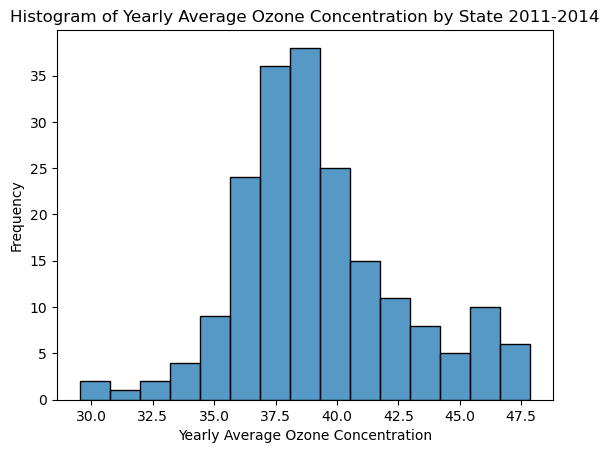

In [19]:
sns.histplot(data=yearly_ozone_avg, x='o3_avg')

plt.xlabel('Yearly Average Ozone Concentration')
plt.ylabel('Frequency')
plt.title('Histogram of Yearly Average Ozone Concentration by State 2011-2014')

plt.show()

## Cardiovascular Disease

In [20]:
cardio.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2016,2016,ID,Idaho,NVSS,Cardiovascular Disease,Mortality from heart failure,NaN,NaN,Number,...,16,CVD,CVD1_4,NMBR,RACE,HIS,NaN,NaN,NaN,NaN
1,2012,2012,MA,Massachusetts,NVSS,Cardiovascular Disease,Mortality from heart failure,NaN,NaN,Number,...,25,CVD,CVD1_4,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
2,2014,2014,MD,Maryland,NVSS,Cardiovascular Disease,Mortality from heart failure,NaN,NaN,Number,...,24,CVD,CVD1_4,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN
3,2014,2014,MS,Mississippi,NVSS,Cardiovascular Disease,Mortality from heart failure,NaN,NaN,Number,...,28,CVD,CVD1_4,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN
4,2011,2011,SD,South Dakota,NVSS,Cardiovascular Disease,Mortality from heart failure,NaN,NaN,Number,...,46,CVD,CVD1_4,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN


In [21]:
cardio.columns

Index(['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'DataSource',
       'Topic', 'Question', 'Response', 'DataValueUnit', 'DataValueType',
       'DataValue', 'DataValueAlt', 'DataValueFootnoteSymbol',
       'DatavalueFootnote', 'LowConfidenceLimit', 'HighConfidenceLimit',
       'StratificationCategory1', 'Stratification1', 'StratificationCategory2',
       'Stratification2', 'StratificationCategory3', 'Stratification3',
       'ResponseID', 'LocationID', 'TopicID', 'QuestionID', 'DataValueTypeID',
       'StratificationCategoryID1', 'StratificationID1',
       'StratificationCategoryID2', 'StratificationID2',
       'StratificationCategoryID3', 'StratificationID3'],
      dtype='object')

In [22]:
cardio_questions = cardio["Question"].unique()
cardio_questions

array(['Mortality from heart failure',
       'Hospitalization for heart failure among Medicare-eligible persons aged >= 65 years',
       'Hospitalization for stroke', 'Pre-pregnancy hypertension',
       'Mortality from total cardiovascular diseases',
       'Mortality from diseases of the heart',
       'Mortality from coronary heart disease',
       'Mortality from cerebrovascular disease (stroke)',
       'Hospitalization for acute myocardial infarction',
       'Cholesterol screening among adults aged >= 18 years',
       'Pneumococcal vaccination among noninstitutionalized adults aged >= 65 years with a history of coronary heart disease',
       'Influenza vaccination among noninstitutionalized adults aged 18-64 years with a history of coronary heart disease or stroke',
       'Awareness of high blood pressure among women aged 18-44 years',
       'High cholesterol prevalence among adults aged >= 18 years',
       'Taking medicine for high blood pressure control among adults age

In [23]:
cardio_strat = cardio['StratificationCategory1'].unique()
cardio_strat

array(['Race/Ethnicity', 'Gender', 'Overall'], dtype=object)

What are the unique values of each columns in cardiovascular dataset?

In [24]:
for column in cardio.columns:
    print(f"Unique values in column '{column}':")
    print(cardio[column].unique())
    print("\n")

Unique values in column 'YearStart':
[2016 2012 2014 2011 2018 2019 2015 2013 2020 2017 2010 2021]


Unique values in column 'YearEnd':
[2016 2012 2014 2011 2018 2019 2015 2013 2020 2017 2010 2021]


Unique values in column 'LocationAbbr':
['ID' 'MA' 'MD' 'MS' 'SD' 'VA' 'IA' 'UT' 'MN' 'US' 'VT' 'IN' 'AL' 'AZ'
 'DE' 'AK' 'CT' 'KY' 'NM' 'TX' 'NC' 'SC' 'NE' 'NV' 'NJ' 'HI' 'GA' 'TN'
 'FL' 'WY' 'MO' 'NY' 'ME' 'LA' 'IL' 'DC' 'OH' 'MI' 'WA' 'RI' 'ND' 'KS'
 'CO' 'CA' 'NH' 'MT' 'OR' 'AR' 'PA' 'OK' 'WI' 'WV' 'GU' 'VI' 'PR']


Unique values in column 'LocationDesc':
['Idaho' 'Massachusetts' 'Maryland' 'Mississippi' 'South Dakota'
 'Virginia' 'Iowa' 'Utah' 'Minnesota' 'United States' 'Vermont' 'Indiana'
 'Alabama' 'Arizona' 'Delaware' 'Alaska' 'Connecticut' 'Kentucky'
 'New Mexico' 'Texas' 'North Carolina' 'South Carolina' 'Nebraska'
 'Nevada' 'New Jersey' 'Hawaii' 'Georgia' 'Tennessee' 'Florida' 'Wyoming'
 'Missouri' 'New York' 'Maine' 'Louisiana' 'Illinois'
 'District of Columbia' 'Ohio' 'Michig

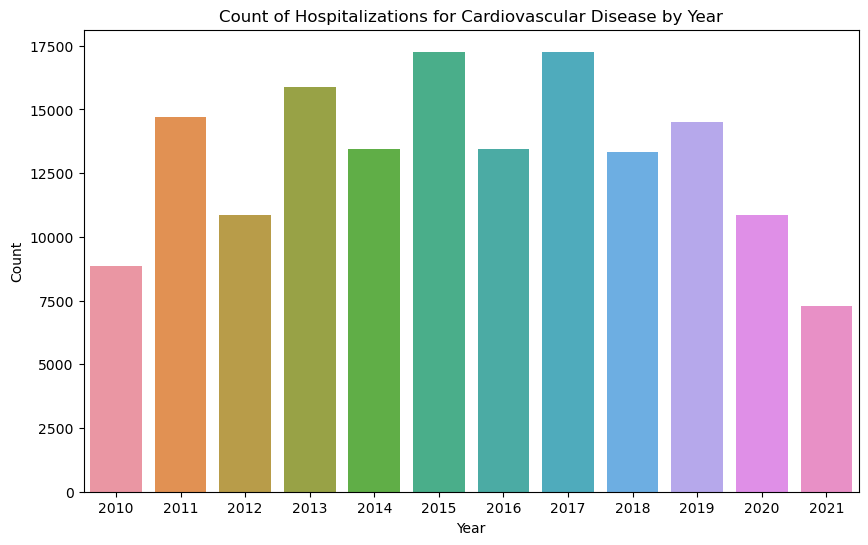

In [25]:

plt.figure(figsize=(10, 6))
sns.countplot(x='YearStart', data=cardio)
plt.title('Count of Hospitalizations for Cardiovascular Disease by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [26]:
print(cardio['DataValue'].describe())

count    113167.000000
mean       1437.111091
std       15384.075658
min           0.180000
25%          35.600000
50%          72.500000
75%         173.500000
max      928741.000000
Name: DataValue, dtype: float64


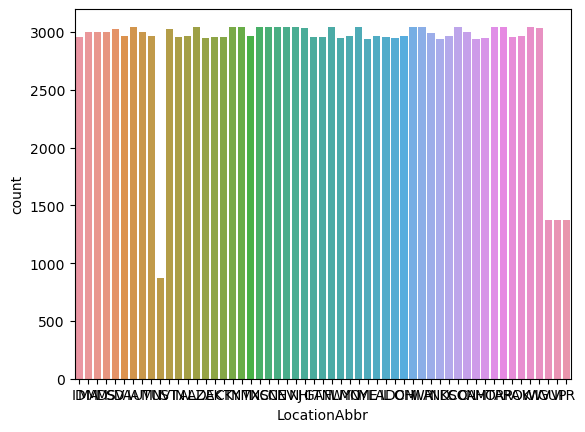

In [27]:
# Bar plot for categorical columns
sns.countplot(data=cardio, x='LocationAbbr')
plt.show()

In [28]:
# for categorical
for col in cardio.select_dtypes(include='object').columns:
    print(cardio[col].value_counts())

WA    3045
WI    3045
FL    3045
NV    3045
NC    3045
NM    3045
NY    3045
CO    3045
AZ    3045
OR    3045
MI    3045
AR    3042
NE    3042
NJ    3039
IA    3039
KY    3039
SC    3039
HI    3036
WV    3030
SD    3027
VT    3021
CA    3003
MS    3003
UT    3003
MA    3000
MD    2997
RI    2994
OH    2961
KS    2961
LA    2961
TX    2961
MO    2961
OK    2961
AL    2961
MN    2961
VA    2961
AK    2958
PA    2955
ID    2955
TN    2955
IL    2955
GA    2955
CT    2955
IN    2955
DC    2949
DE    2949
MT    2946
WY    2946
ND    2943
ME    2940
NH    2937
GU    1377
VI    1377
PR    1377
US     868
Name: LocationAbbr, dtype: int64
Washington              3045
Wisconsin               3045
Florida                 3045
Nevada                  3045
North Carolina          3045
New Mexico              3045
New York                3045
Colorado                3045
Arizona                 3045
Oregon                  3045
Michigan                3045
Arkansas                3042
Nebraska      

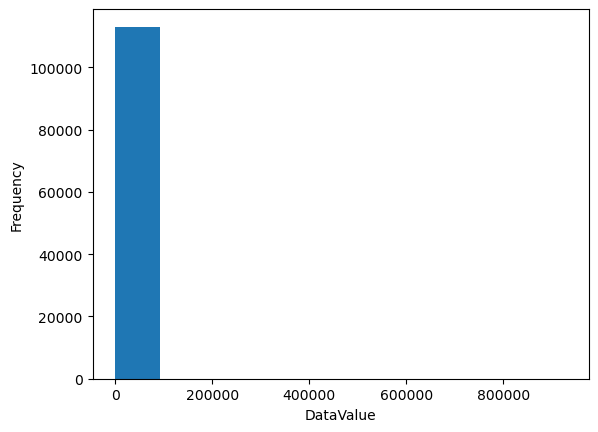

In [29]:
# Histogram for continuous columns
plt.hist(cardio['DataValue'])
plt.xlabel('DataValue')
plt.ylabel('Frequency')
plt.show()

In [30]:
#hypothesis testing, maybe?
from scipy.stats import ttest_ind

male_data = cardio[cardio['StratificationID1'] == 'GENM']['DataValue']
female_data = cardio[cardio['StratificationID1'] == 'GENF']['DataValue']

t_stat, p_value = ttest_ind(male_data.dropna(), female_data.dropna())
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 0.2819958748315624
p-value: 0.7779482879000573


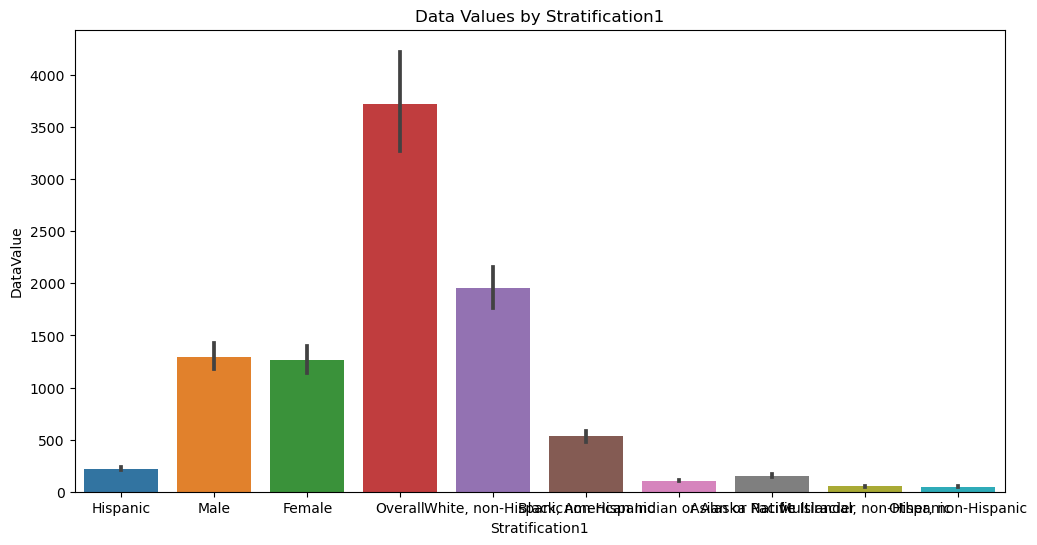

In [31]:
# stratification1:
# Bar plot of Data Values by Stratification1
plt.figure(figsize=(12, 6))
sns.barplot(data=cardio, x='Stratification1', y='DataValue')
plt.xlabel('Stratification1')
plt.ylabel('DataValue')
plt.title('Data Values by Stratification1')
plt.show()

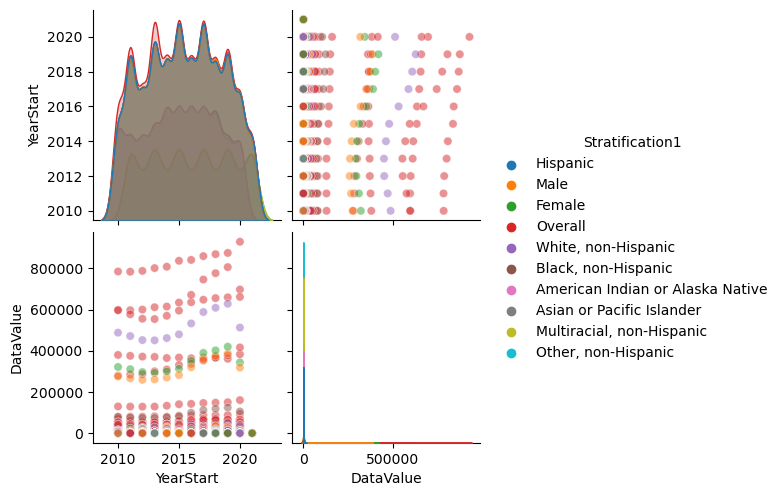

In [32]:
#Pairwise relationships for 'DataValue' and 'YearStart'
sns.pairplot(data=cardio, vars=['YearStart', 'DataValue'], hue='Stratification1', plot_kws={'alpha': 0.5})
plt.show()

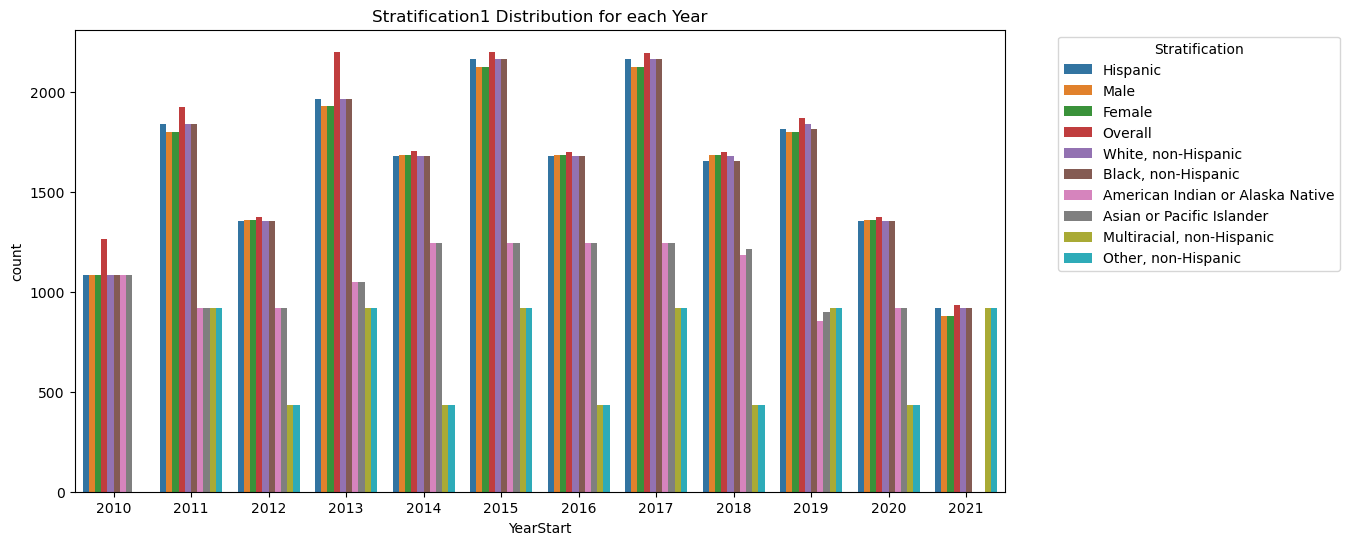

In [33]:
# Stratification1 Distribution for each Year
plt.figure(figsize=(12, 6))
sns.countplot(data=cardio, x='YearStart', hue='Stratification1')
plt.title('Stratification1 Distribution for each Year')
plt.legend(title='Stratification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

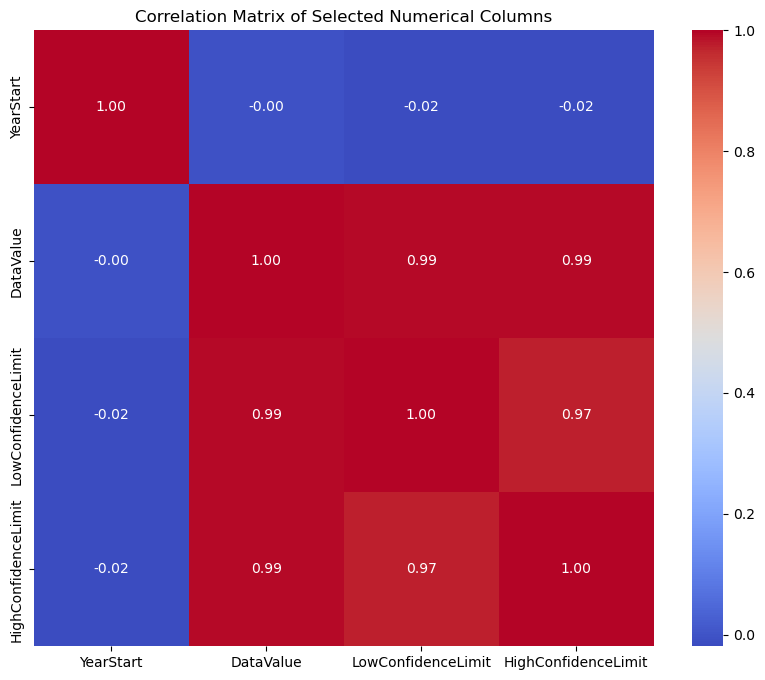

In [34]:
# Pair plot of selected numerical columns
selected_columns = ['YearStart', 'DataValue', 'LowConfidenceLimit', 'HighConfidenceLimit']

# Correlation matrix of selected numerical columns
correlation_matrix = cardio[selected_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f")
plt.title('Correlation Matrix of Selected Numerical Columns')
plt.show()

## Asthma

In [35]:
asthma.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2014,2014,AR,Arkansas,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,5,AST,AST3_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
1,2018,2018,CO,Colorado,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,8,AST,AST3_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
2,2018,2018,DC,District of Columbia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,11,AST,AST3_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
3,2017,2017,GA,Georgia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,13,AST,AST3_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN
4,2010,2010,MI,Michigan,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,26,AST,AST3_1,NMBR,RACE,HIS,NaN,NaN,NaN,NaN


In [36]:
asthma.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2014,2014,AR,Arkansas,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,5,AST,AST3_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
1,2018,2018,CO,Colorado,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,8,AST,AST3_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
2,2018,2018,DC,District of Columbia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,11,AST,AST3_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
3,2017,2017,GA,Georgia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,13,AST,AST3_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN
4,2010,2010,MI,Michigan,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,26,AST,AST3_1,NMBR,RACE,HIS,NaN,NaN,NaN,NaN


In [37]:
data = asthma

# Print unique values of each column
for column in data.columns:
    print(f"Unique values in column '{column}':")
    print(data[column].unique())
    print("\n")

Unique values in column 'YearStart':
[2014 2018 2017 2010 2015 2013 2016 2020 2012 2019 2011 2021]


Unique values in column 'YearEnd':
[2014 2018 2017 2010 2015 2013 2016 2020 2012 2019 2011 2021]


Unique values in column 'LocationAbbr':
['AR' 'CO' 'DC' 'GA' 'MI' 'MT' 'OR' 'PR' 'WI' 'AL' 'ID' 'IL' 'KS' 'LA'
 'MA' 'MD' 'MN' 'MS' 'NC' 'NM' 'TX' 'MO' 'CA' 'AZ' 'WA' 'NY' 'AK' 'GU'
 'ND' 'SD' 'IN' 'NE' 'WY' 'OH' 'ME' 'NV' 'FL' 'NJ' 'DE' 'CT' 'WV' 'KY'
 'TN' 'NH' 'VI' 'VT' 'VA' 'HI' 'IA' 'PA' 'UT' 'RI' 'SC' 'OK' 'US']


Unique values in column 'LocationDesc':
['Arkansas' 'Colorado' 'District of Columbia' 'Georgia' 'Michigan'
 'Montana' 'Oregon' 'Puerto Rico' 'Wisconsin' 'Alabama' 'Idaho' 'Illinois'
 'Kansas' 'Louisiana' 'Massachusetts' 'Maryland' 'Minnesota' 'Mississippi'
 'North Carolina' 'New Mexico' 'Texas' 'Missouri' 'California' 'Arizona'
 'Washington' 'New York' 'Alaska' 'Guam' 'North Dakota' 'South Dakota'
 'Indiana' 'Nebraska' 'Wyoming' 'Ohio' 'Maine' 'Nevada' 'Florida'
 'New Jerse

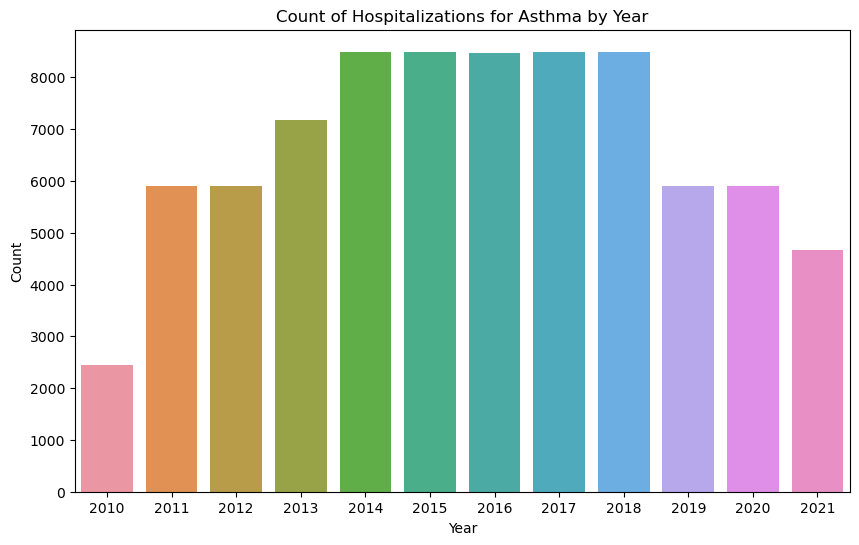

In [38]:
plt.figure(figsize=(10, 6))
sns.countplot(x='YearStart', data=asthma)
plt.title('Count of Hospitalizations for Asthma by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [39]:
# for continuous
print(asthma['DataValue'].describe())

count     39846.000000
mean        356.905720
std        3856.223975
min           0.000000
25%          11.500000
50%          36.800000
75%          63.800000
max      222051.000000
Name: DataValue, dtype: float64


In [40]:
# for categorical
for col in asthma.select_dtypes(include='object').columns:
    print(asthma[col].value_counts())

NY    1531
WI    1531
AZ    1531
NE    1531
NV    1531
FL    1531
NC    1531
NJ    1531
KY    1531
SC    1531
VT    1531
IA    1531
WV    1516
HI    1516
SD    1516
CO    1516
WA    1516
NM    1516
AR    1516
MI    1516
OR    1516
MS    1495
RI    1495
MA    1495
UT    1495
MD    1495
CA    1495
AK    1474
PA    1474
DC    1474
VA    1474
MO    1474
MT    1474
NH    1474
TN    1474
OK    1474
CT    1474
DE    1474
AL    1474
ID    1474
TX    1474
ME    1474
OH    1474
WY    1474
KS    1474
IN    1474
LA    1474
ND    1474
MN    1474
IL    1474
GA    1450
GU    1210
VI    1210
PR    1210
US     374
Name: LocationAbbr, dtype: int64
New York                1531
Wisconsin               1531
Arizona                 1531
Nebraska                1531
Nevada                  1531
Florida                 1531
North Carolina          1531
New Jersey              1531
Kentucky                1531
South Carolina          1531
Vermont                 1531
Iowa                    1531
West Virginia 

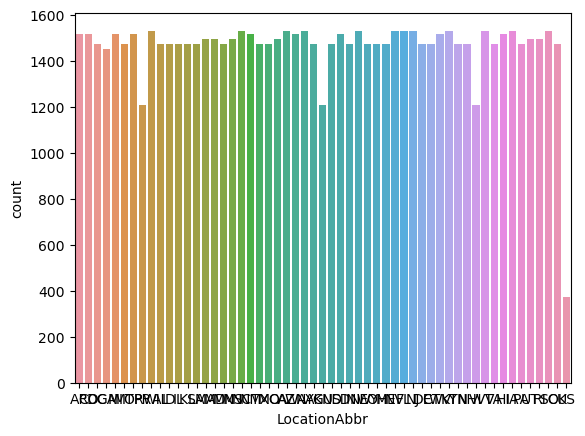

In [41]:
# Bar plot for categorical columns
sns.countplot(data=data, x='LocationAbbr')
plt.show()

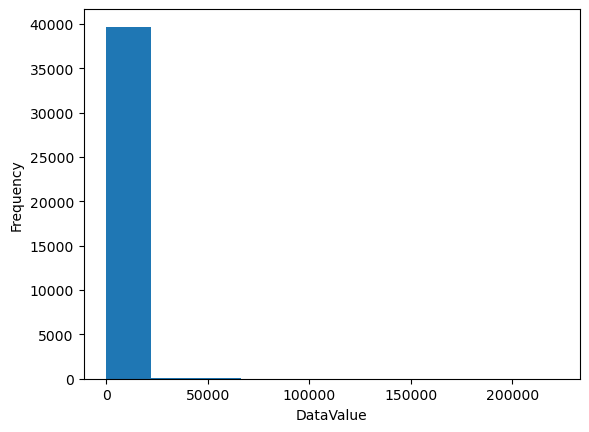

In [42]:
# Histogram for continuous columns
plt.hist(asthma['DataValue'])
plt.xlabel('DataValue')
plt.ylabel('Frequency')
plt.show()

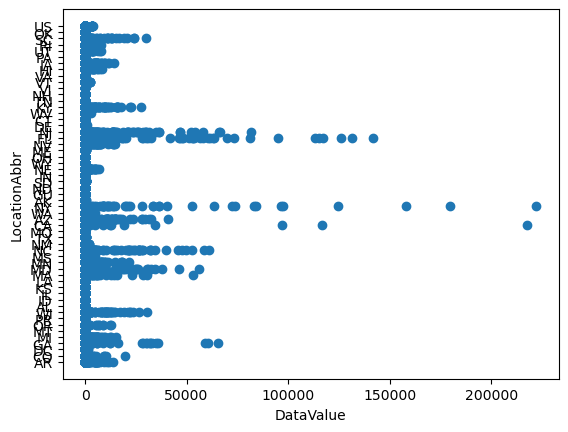

In [43]:
# Scatter plot
plt.scatter(asthma['DataValue'], asthma['LocationAbbr'])
plt.xlabel('DataValue')
plt.ylabel('LocationAbbr')
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


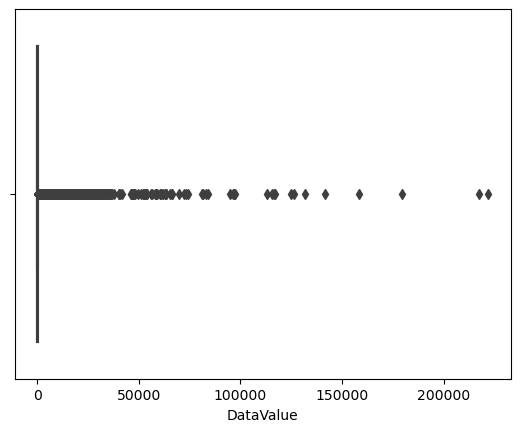

In [44]:
#find outliers:
sns.boxplot(asthma['DataValue'].dropna())
plt.show()

In [45]:
#hypothesis testing, maybe?
from scipy.stats import ttest_ind

male_data = asthma[asthma['StratificationID1'] == 'GENM']['DataValue']
female_data = asthma[asthma['StratificationID1'] == 'GENF']['DataValue']

t_stat, p_value = ttest_ind(male_data.dropna(), female_data.dropna())
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -0.6120987620462535
p-value: 0.5404820421509307


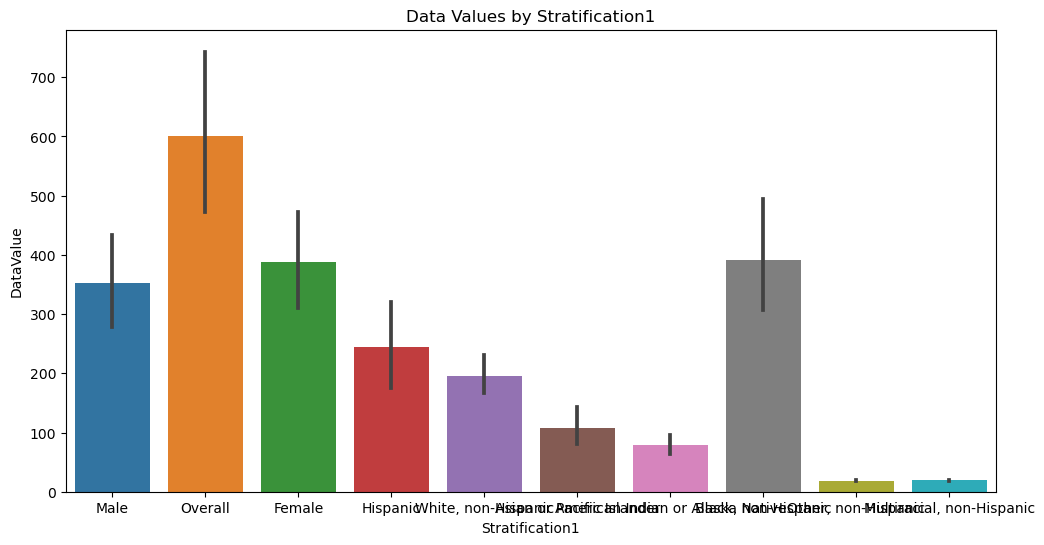

In [46]:
# stratification1:
# Bar plot of Data Values by Stratification1
plt.figure(figsize=(12, 6))
sns.barplot(data=asthma, x='Stratification1', y='DataValue')
plt.xlabel('Stratification1')
plt.ylabel('DataValue')
plt.title('Data Values by Stratification1')
plt.show()

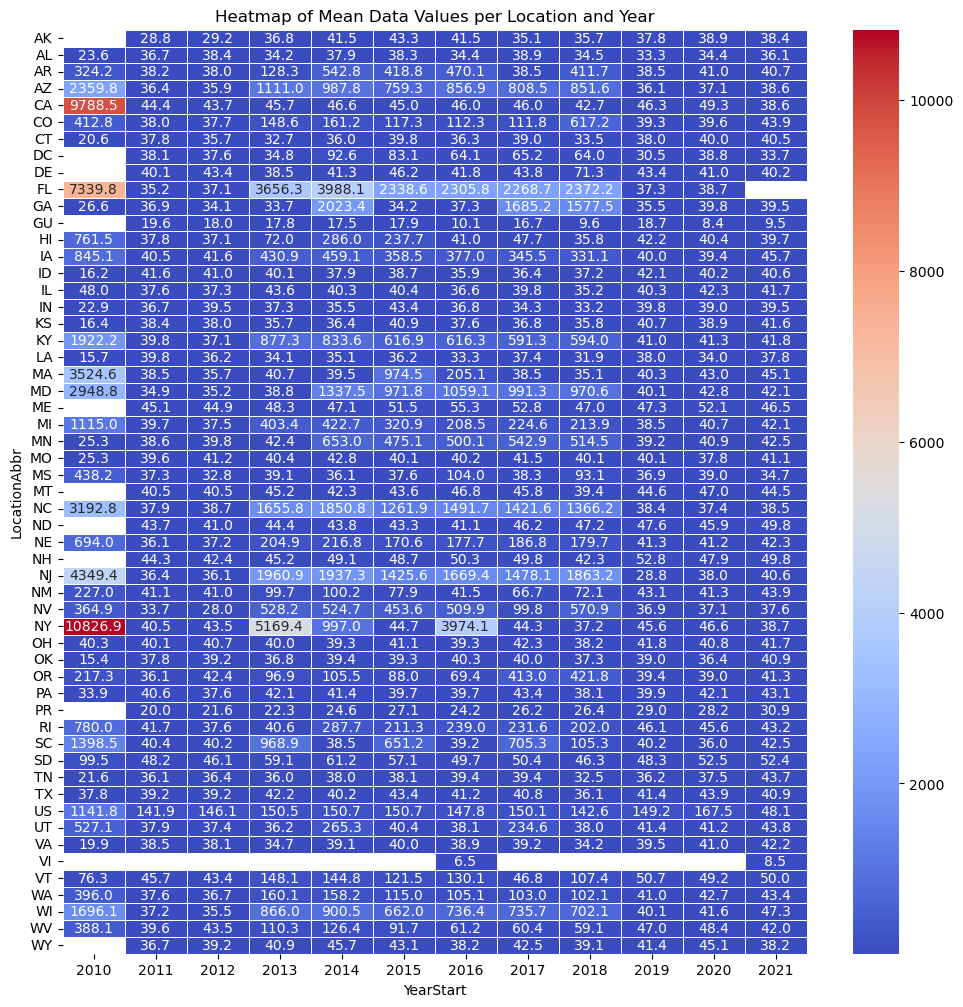

In [47]:
# heat maps:
pivot_table = asthma.pivot_table(index='LocationAbbr', columns='YearStart', values='DataValue', aggfunc='mean')
plt.figure(figsize=(12, 12))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt='.1f', linewidths=0.5)
plt.title('Heatmap of Mean Data Values per Location and Year')
plt.show()

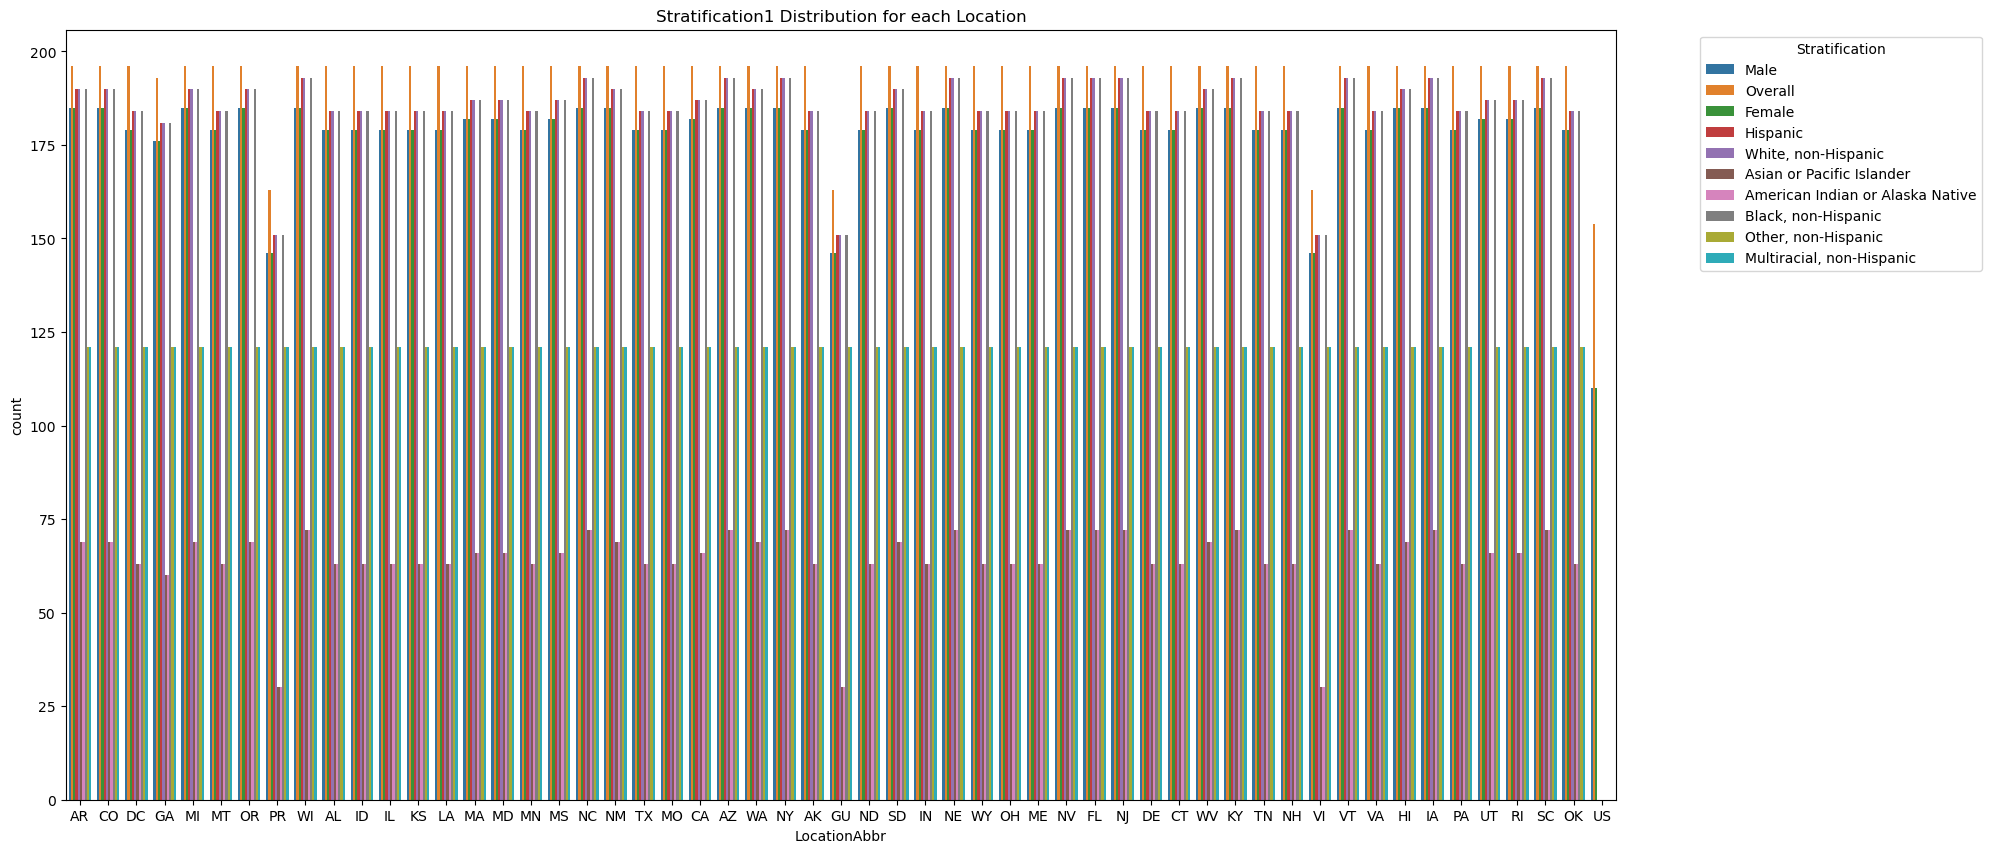

In [48]:
# Stratification1 Distribution for each Location
plt.figure(figsize=(20, 10))
sns.countplot(data=asthma, x='LocationAbbr', hue='Stratification1')
plt.title('Stratification1 Distribution for each Location')
plt.legend(title='Stratification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

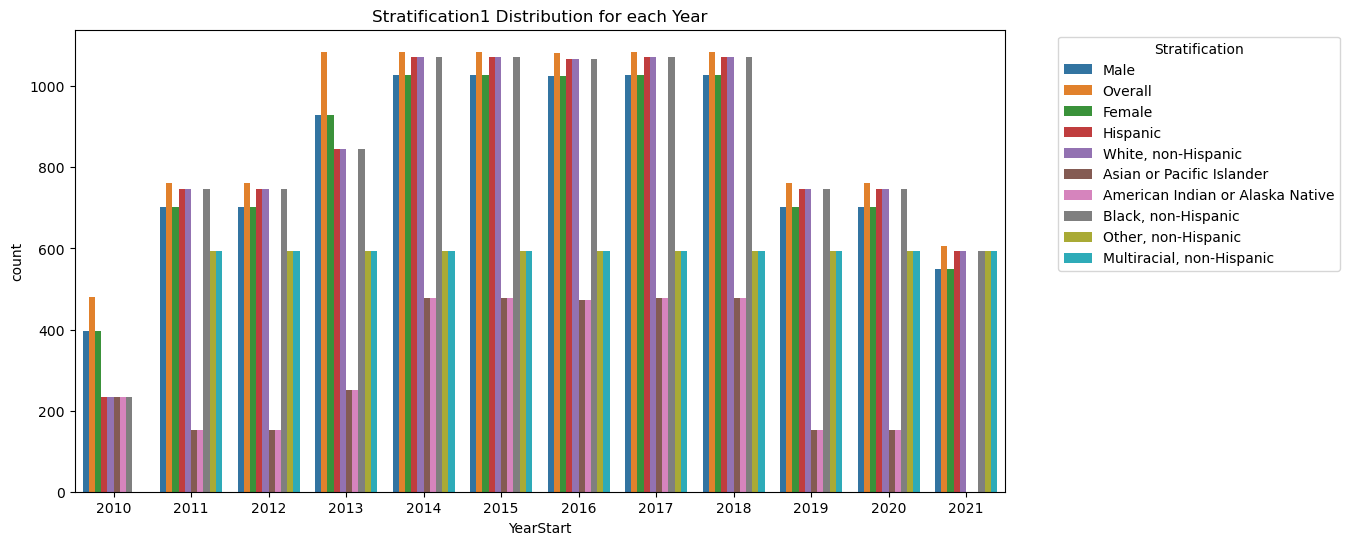

In [49]:
# Stratification1 Distribution for each Year
plt.figure(figsize=(12, 6))
sns.countplot(data=asthma, x='YearStart', hue='Stratification1')
plt.title('Stratification1 Distribution for each Year')
plt.legend(title='Stratification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

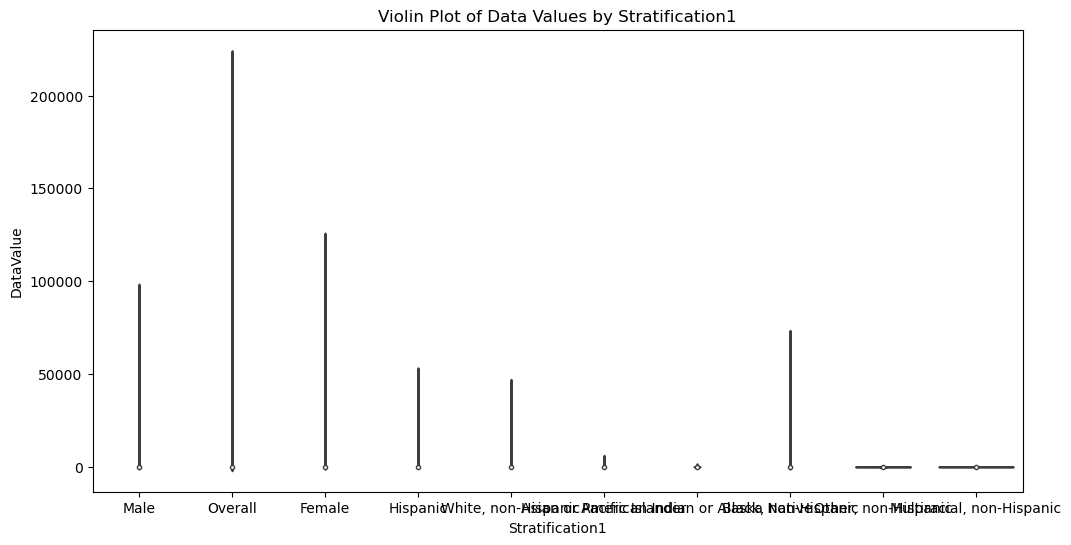

In [50]:
# Violin plot of Data Values by Stratification1
plt.figure(figsize=(12, 6))
sns.violinplot(data=asthma, x='Stratification1', y='DataValue')
plt.xlabel('Stratification1')
plt.ylabel('DataValue')
plt.title('Violin Plot of Data Values by Stratification1')
plt.show()

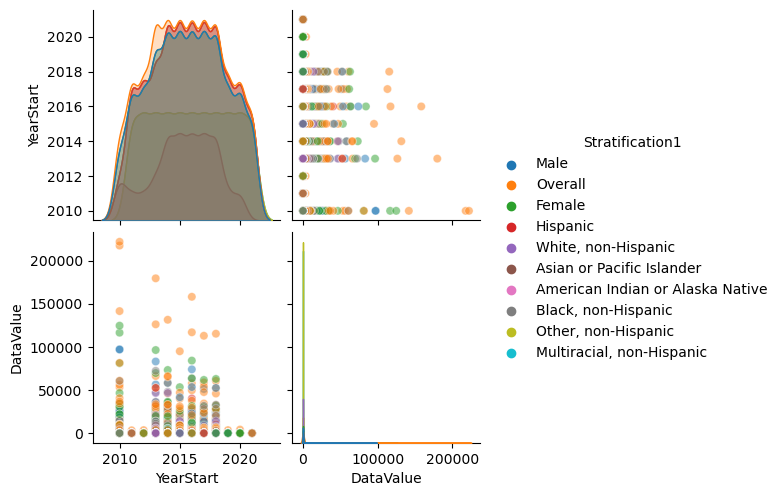

In [51]:
#Pairwise relationships for 'DataValue' and 'YearStart'
sns.pairplot(data=asthma, vars=['YearStart', 'DataValue'], hue='Stratification1', plot_kws={'alpha': 0.5})
plt.show()

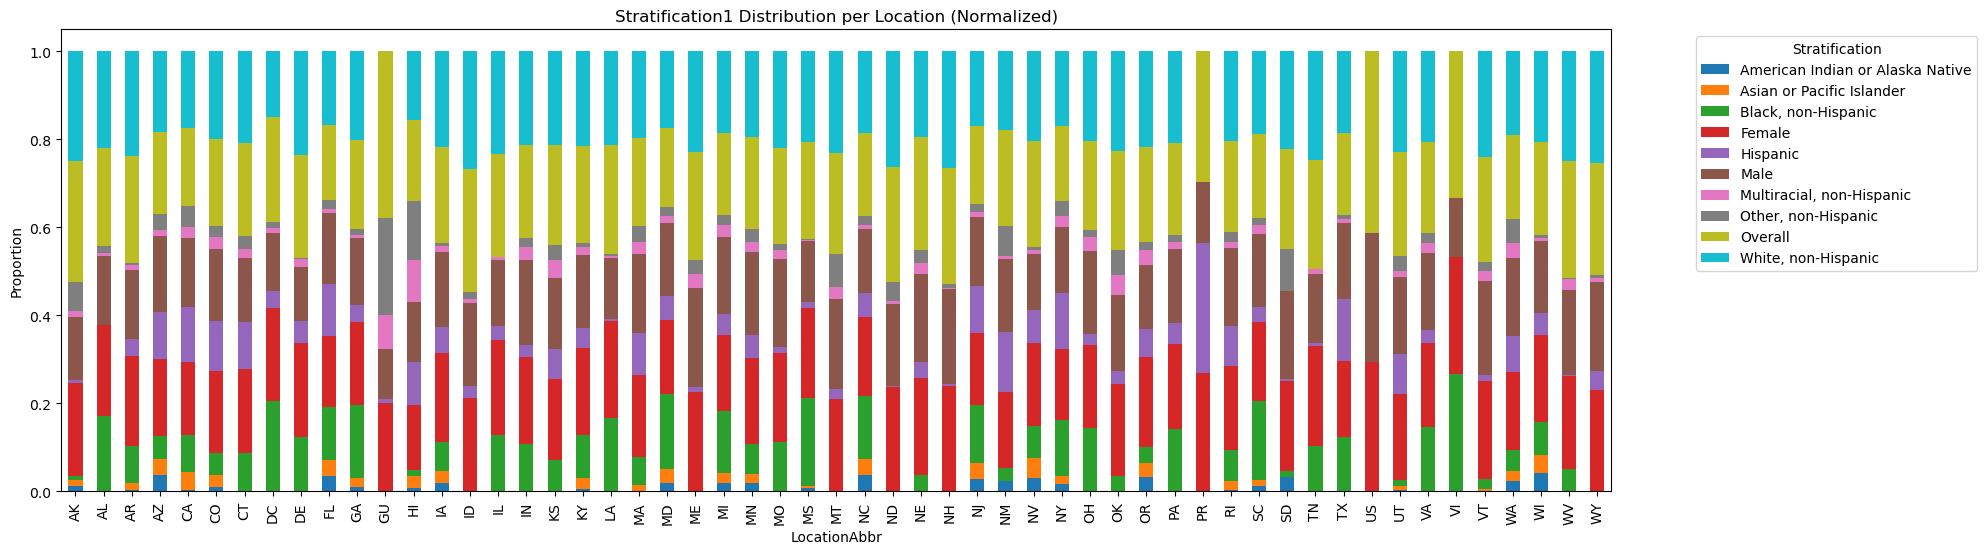

In [52]:
#Stacked bar plot of Stratification1 per Location
stacked_data = asthma.groupby(['LocationAbbr', 'Stratification1'])['DataValue'].count().unstack().fillna(0)
stacked_data = stacked_data.div(stacked_data.sum(axis=1), axis=0)
stacked_data.plot(kind='bar', stacked=True, figsize=(20, 6))
plt.title('Stratification1 Distribution per Location (Normalized)')
plt.ylabel('Proportion')
plt.legend(title='Stratification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

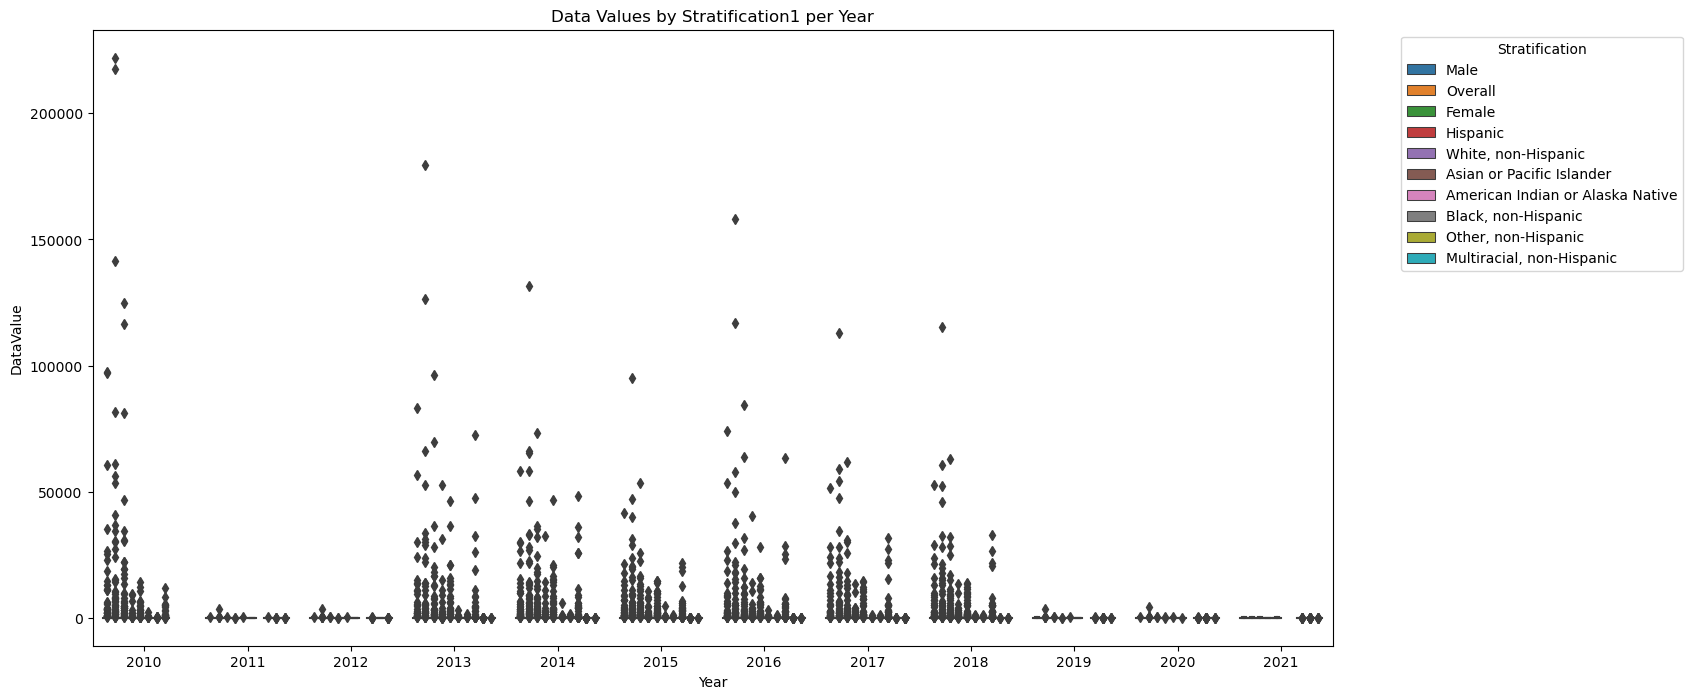

In [53]:
# Grouped box plot of Data Values by Stratification1 per Year
plt.figure(figsize=(16, 8))
sns.boxplot(data=asthma, x='YearStart', y='DataValue', hue='Stratification1')
plt.xlabel('Year')
plt.ylabel('DataValue')
plt.title('Data Values by Stratification1 per Year')
plt.legend(title='Stratification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

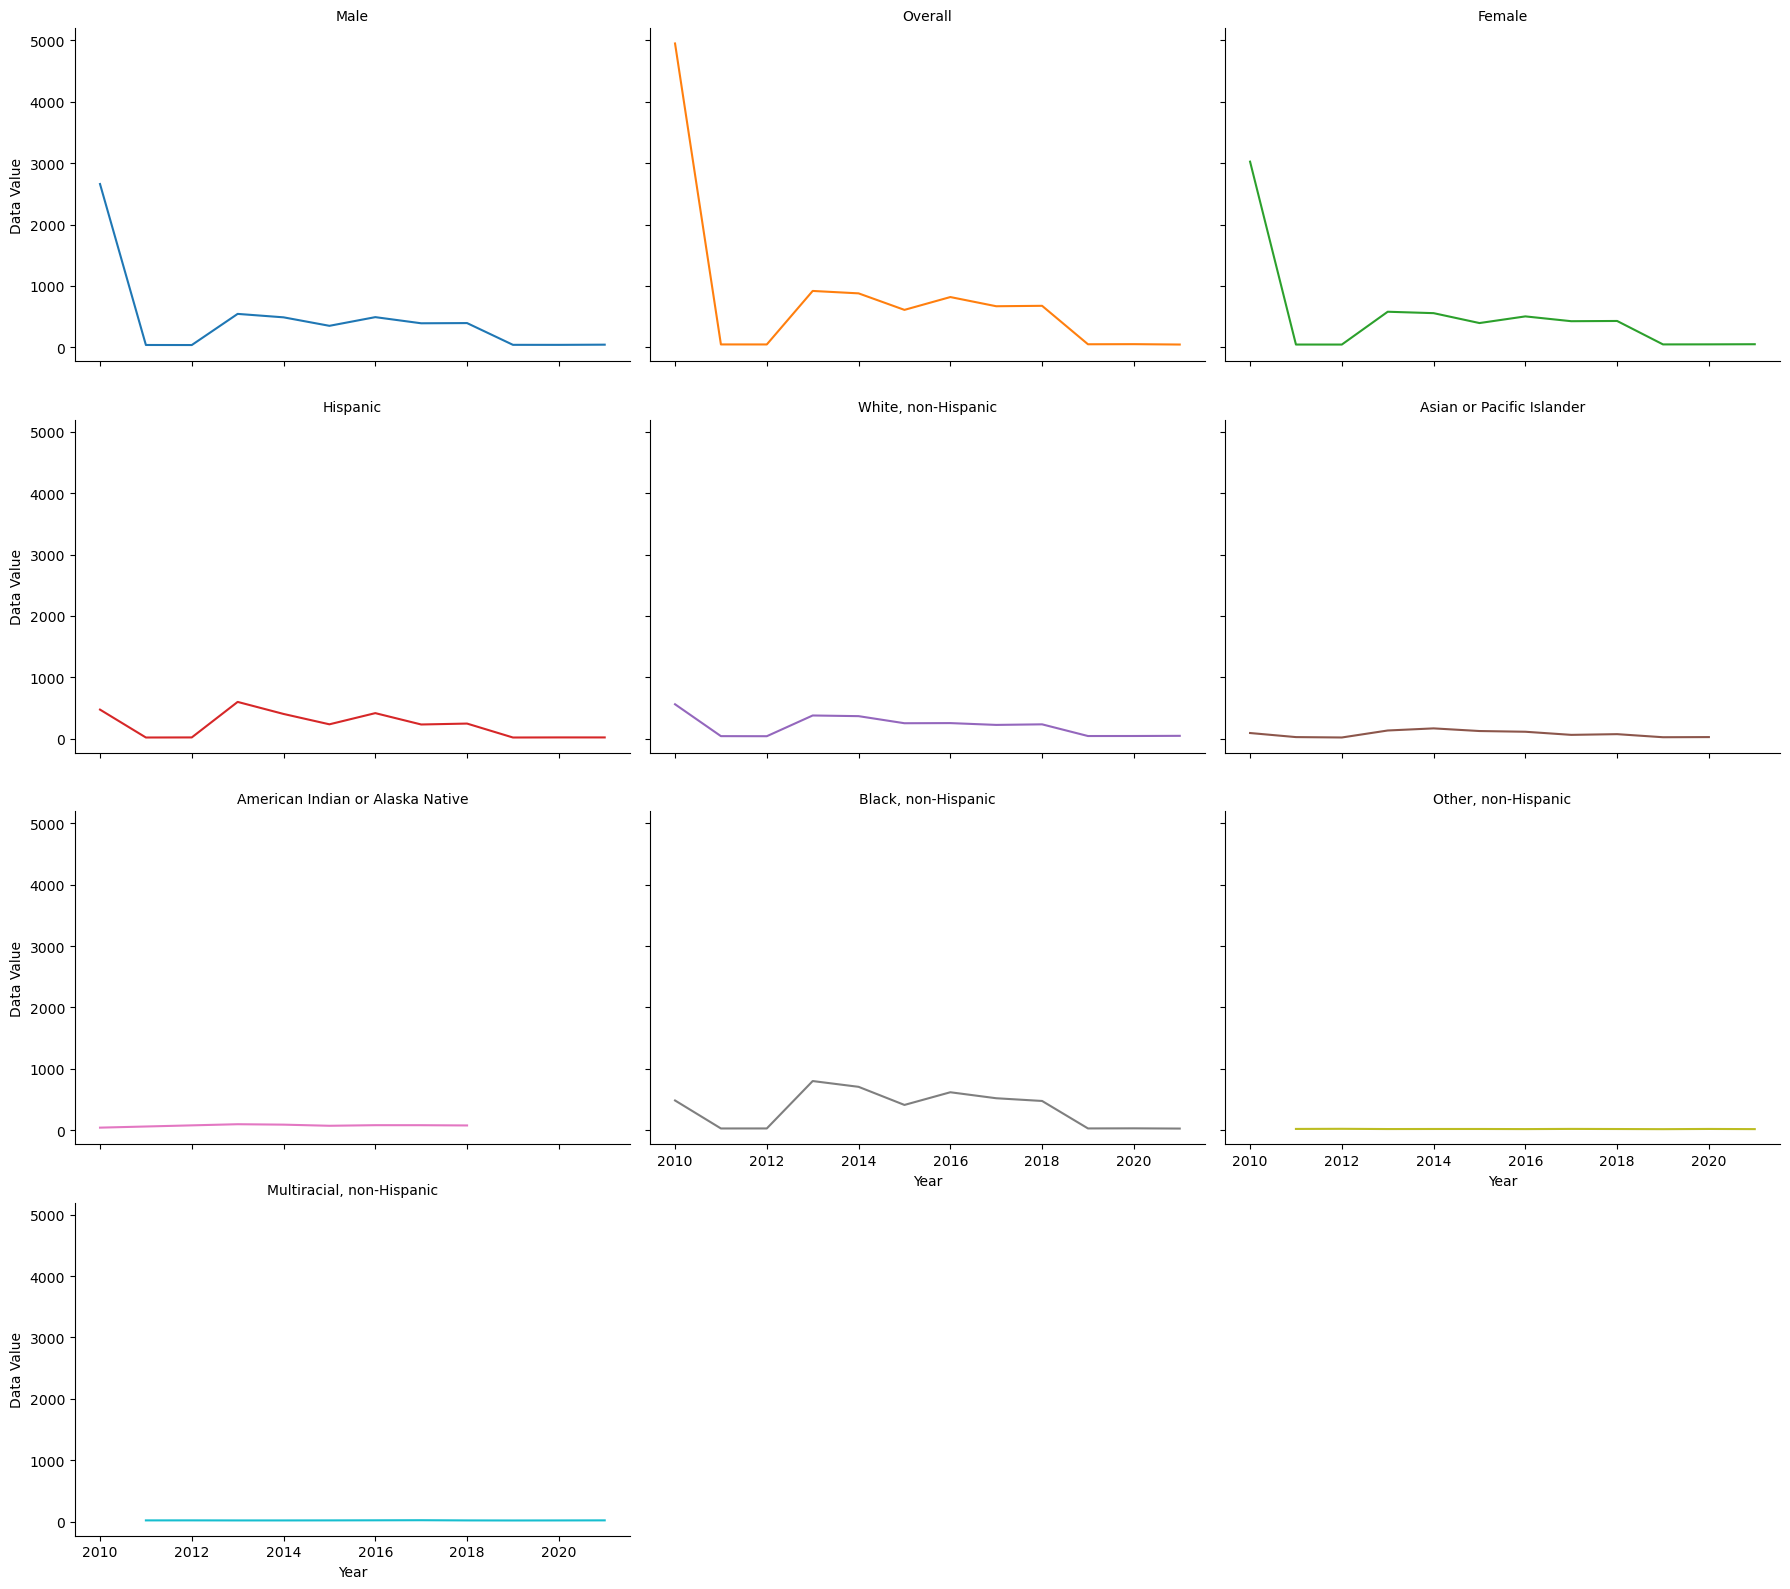

In [54]:
#Facet grid plot of Data Values by Stratification1 per Year
g = sns.FacetGrid(asthma, col='Stratification1', hue='Stratification1', col_wrap=3, height=4, aspect=1.5)
g.map(sns.lineplot, 'YearStart', 'DataValue', ci=None)
g.set_titles("{col_name}")
g.set_axis_labels("Year", "Data Value")
plt.show()

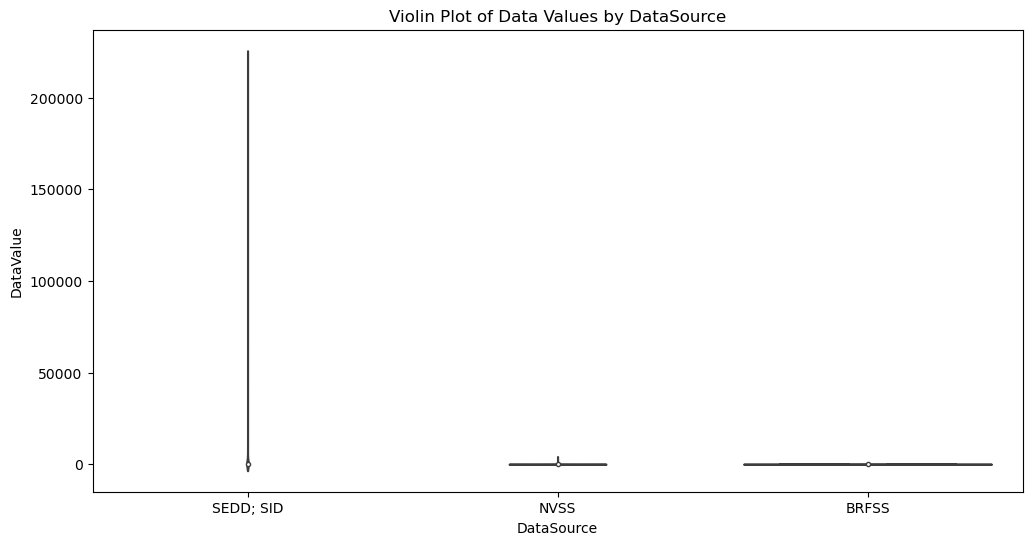

In [55]:
# Distribution of DataValue by DataSource
plt.figure(figsize=(12, 6))
sns.violinplot(data=asthma, x='DataSource', y='DataValue')
plt.xlabel('DataSource')
plt.ylabel('DataValue')
plt.title('Violin Plot of Data Values by DataSource')
plt.show()

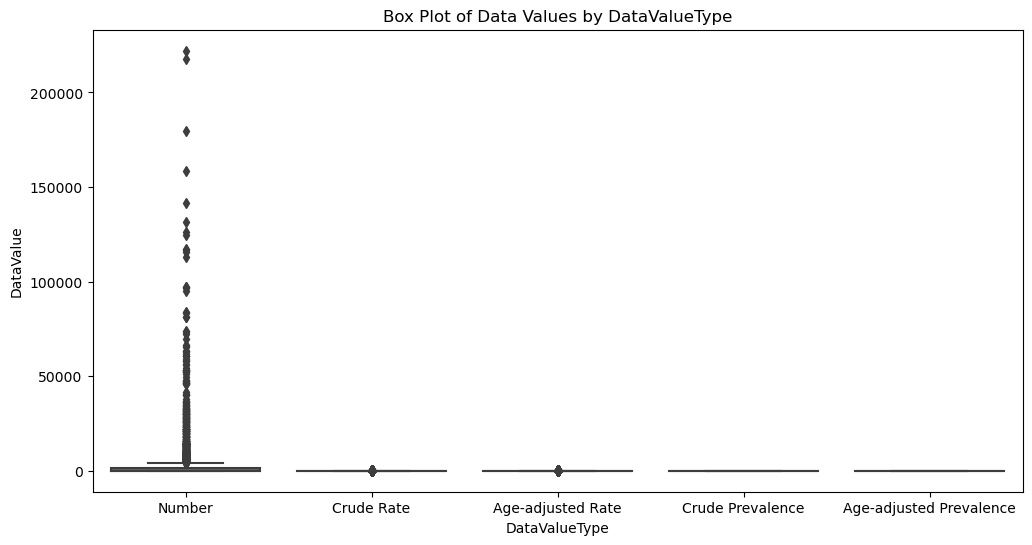

In [56]:
#  Distribution of DataValue by DataValueType
plt.figure(figsize=(12, 6))
sns.boxplot(data=asthma, x='DataValueType', y='DataValue')
plt.xlabel('DataValueType')
plt.ylabel('DataValue')
plt.title('Box Plot of Data Values by DataValueType')
plt.show()

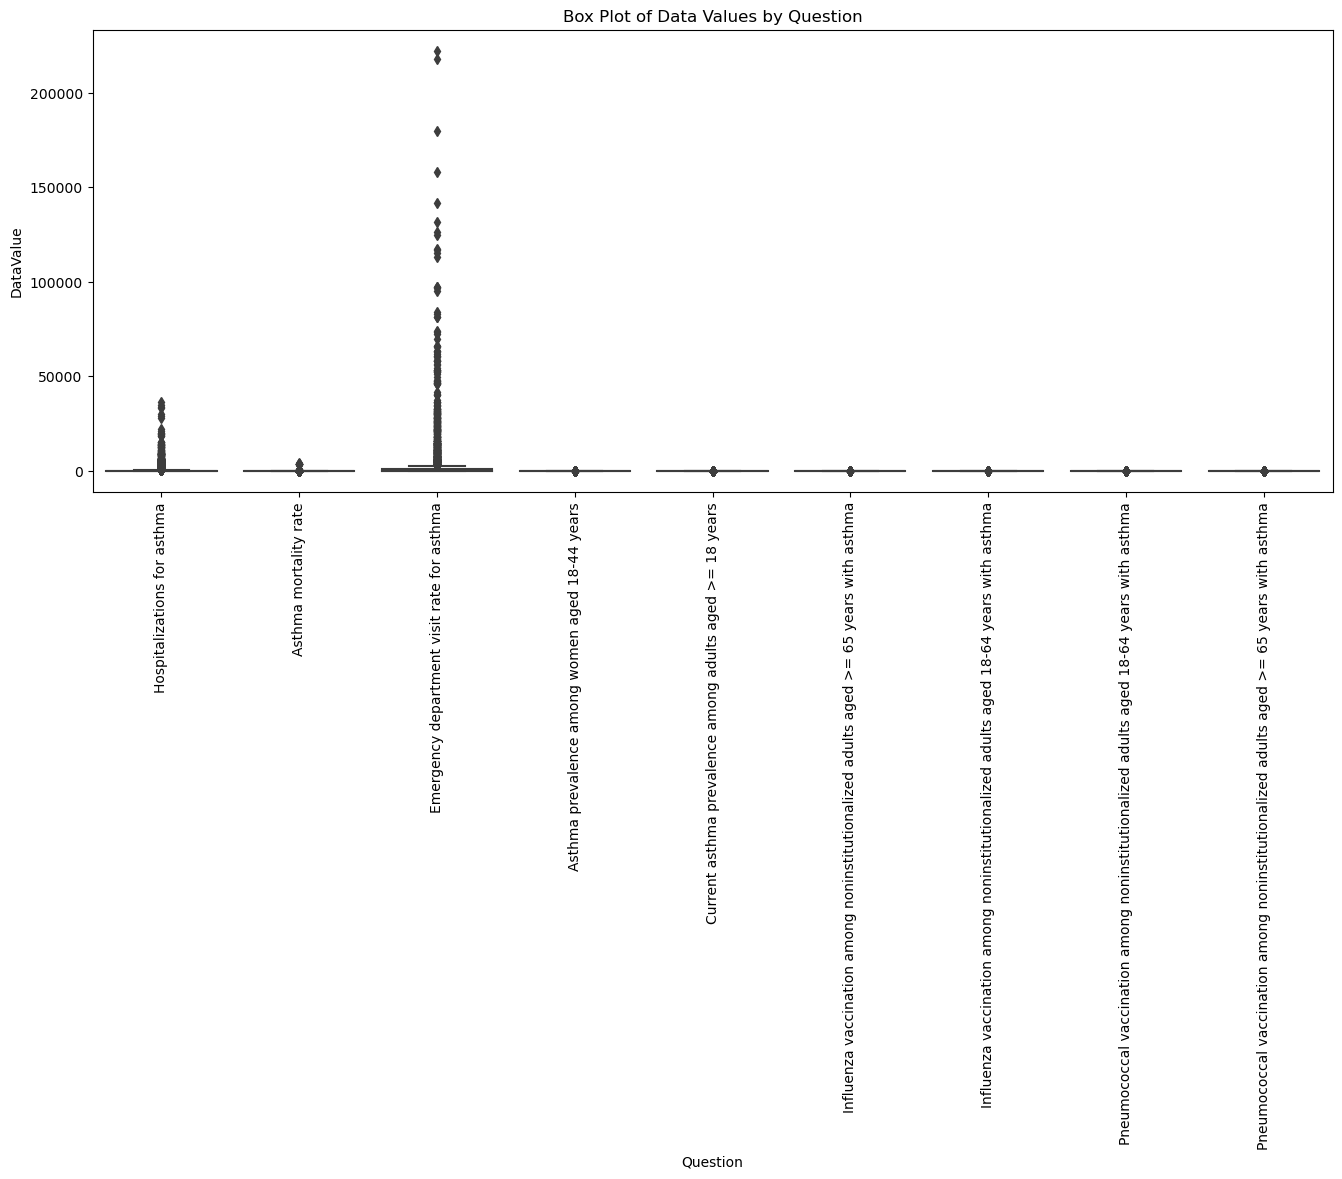

In [57]:
# Distribution of DataValue by Question
plt.figure(figsize=(16, 6))
sns.boxplot(data=asthma, x='Question', y='DataValue')
plt.xticks(rotation=90)
plt.xlabel('Question')
plt.ylabel('DataValue')
plt.title('Box Plot of Data Values by Question')
plt.show()

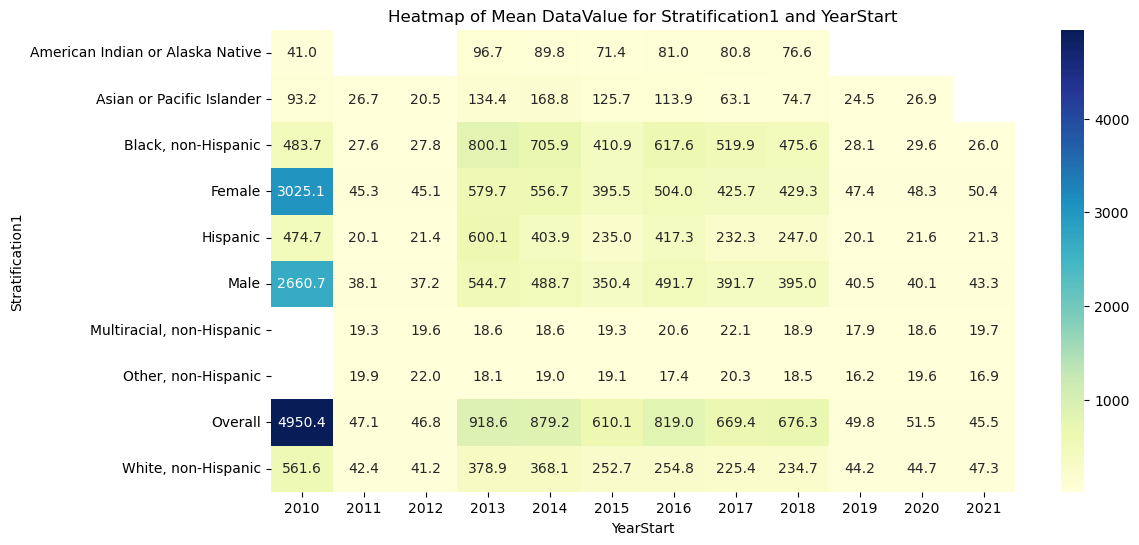

In [58]:
# Heatmap of DataValue for Stratification1 and YearStart
pivot_data = asthma.pivot_table(index='Stratification1', columns='YearStart', values='DataValue', aggfunc='mean')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title('Heatmap of Mean DataValue for Stratification1 and YearStart')
plt.show()

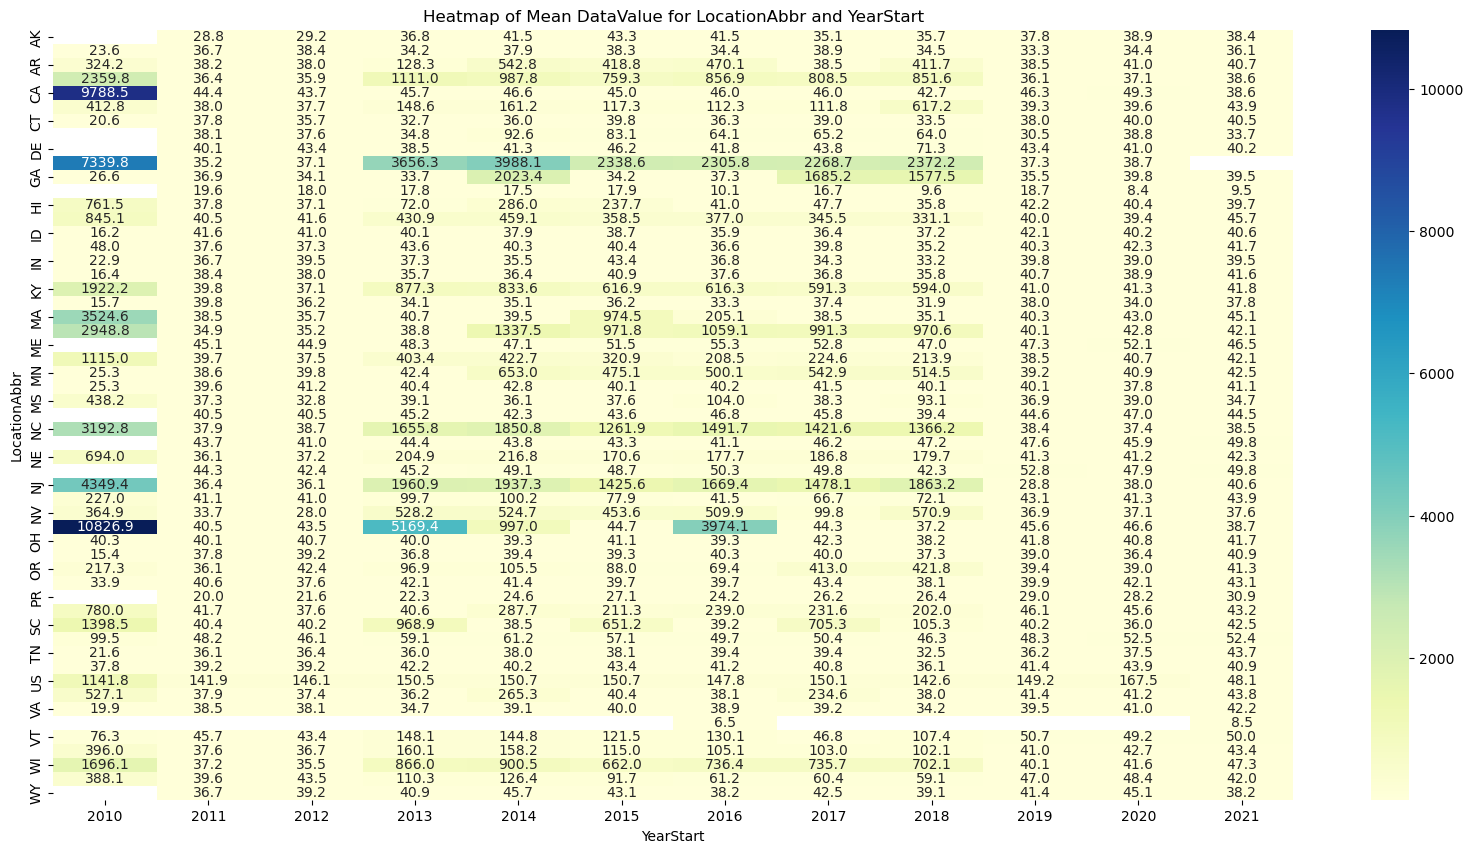

In [59]:
# Heatmap of DataValue for LocationAbbr and YearStart
pivot_data = asthma.pivot_table(index='LocationAbbr', columns='YearStart', values='DataValue', aggfunc='mean')
plt.figure(figsize=(20, 10))
sns.heatmap(pivot_data, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title('Heatmap of Mean DataValue for LocationAbbr and YearStart')
plt.show()

In [60]:
'''
#Mean DataValue by YearStart for each Stratification1
plt.figure(figsize=(12, 6))
sns.lineplot(data=asthma, x='YearStart', y='DataValue', hue='Stratification1', ci=None)
plt.xlabel('Year')
plt.ylabel('Mean DataValue')
plt.title('Mean DataValue by YearStart for each Stratification1')
plt.legend(title='Stratification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
'''

"\n#Mean DataValue by YearStart for each Stratification1\nplt.figure(figsize=(12, 6))\nsns.lineplot(data=asthma, x='YearStart', y='DataValue', hue='Stratification1', ci=None)\nplt.xlabel('Year')\nplt.ylabel('Mean DataValue')\nplt.title('Mean DataValue by YearStart for each Stratification1')\nplt.legend(title='Stratification', bbox_to_anchor=(1.05, 1), loc='upper left')\nplt.show()\n"

In [61]:
'''
# Trend of Mean DataValue by YearStart for each DataSource
plt.figure(figsize=(12, 6))
sns.lineplot(data=asthma, x='YearStart', y='DataValue', hue='DataSource', ci=None)
plt.xlabel('Year')
plt.ylabel('Mean DataValue')
plt.title('Mean DataValue Trend by YearStart for each DataSource')
plt.legend(title='DataSource', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
'''

"\n# Trend of Mean DataValue by YearStart for each DataSource\nplt.figure(figsize=(12, 6))\nsns.lineplot(data=asthma, x='YearStart', y='DataValue', hue='DataSource', ci=None)\nplt.xlabel('Year')\nplt.ylabel('Mean DataValue')\nplt.title('Mean DataValue Trend by YearStart for each DataSource')\nplt.legend(title='DataSource', bbox_to_anchor=(1.05, 1), loc='upper left')\nplt.show()\n"

In [62]:
'''
# Distribution of DataValue by Stratification1
plt.figure(figsize=(12, 6))
sns.boxplot(data=asthma, x='Stratification1', y='DataValue')
plt.xlabel('Stratification1')
plt.ylabel('DataValue')
plt.title('Box Plot of Data Values by Stratification1')
plt.show()
'''

"\n# Distribution of DataValue by Stratification1\nplt.figure(figsize=(12, 6))\nsns.boxplot(data=asthma, x='Stratification1', y='DataValue')\nplt.xlabel('Stratification1')\nplt.ylabel('DataValue')\nplt.title('Box Plot of Data Values by Stratification1')\nplt.show()\n"

In [63]:
'''
# Distribution of DataValue by TopicID
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='TopicID', y='DataValue')
plt.xlabel('TopicID')
plt.ylabel('DataValue')
plt.title('Box Plot of Data Values by TopicID')
plt.show()
'''

"\n# Distribution of DataValue by TopicID\nplt.figure(figsize=(12, 6))\nsns.boxplot(data=data, x='TopicID', y='DataValue')\nplt.xlabel('TopicID')\nplt.ylabel('DataValue')\nplt.title('Box Plot of Data Values by TopicID')\nplt.show()\n"

In [64]:
'''
# Pair plot of selected numerical columns
selected_columns = ['YearStart', 'DataValue', 'LowConfidenceLimit', 'HighConfidenceLimit']
sns.pairplot(data[selected_columns])
plt.show()
'''

"\n# Pair plot of selected numerical columns\nselected_columns = ['YearStart', 'DataValue', 'LowConfidenceLimit', 'HighConfidenceLimit']\nsns.pairplot(data[selected_columns])\nplt.show()\n"

In [65]:
'''
# Correlation matrix of selected numerical columns
correlation_matrix = asthma[selected_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f")
plt.title('Correlation Matrix of Selected Numerical Columns')
plt.show()
'''

'\n# Correlation matrix of selected numerical columns\ncorrelation_matrix = asthma[selected_columns].corr()\nplt.figure(figsize=(10, 8))\nsns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f")\nplt.title(\'Correlation Matrix of Selected Numerical Columns\')\nplt.show()\n'

In [66]:
'''
#  Scatter plot of LowConfidenceLimit vs HighConfidenceLimit by Stratification1
plt.figure(figsize=(12, 6))
sns.scatterplot(data=asthma, x='LowConfidenceLimit', y='HighConfidenceLimit', hue='Stratification1', alpha=0.5)
plt.xlabel('LowConfidenceLimit')
plt.ylabel('HighConfidenceLimit')
plt.title('Scatter Plot of LowConfidenceLimit vs HighConfidenceLimit by Stratification1')
plt.legend(title='Stratification1', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
'''

"\n#  Scatter plot of LowConfidenceLimit vs HighConfidenceLimit by Stratification1\nplt.figure(figsize=(12, 6))\nsns.scatterplot(data=asthma, x='LowConfidenceLimit', y='HighConfidenceLimit', hue='Stratification1', alpha=0.5)\nplt.xlabel('LowConfidenceLimit')\nplt.ylabel('HighConfidenceLimit')\nplt.title('Scatter Plot of LowConfidenceLimit vs HighConfidenceLimit by Stratification1')\nplt.legend(title='Stratification1', bbox_to_anchor=(1.05, 1), loc='upper left')\nplt.show()\n"

In [67]:
'''
# Bar plot of average DataValue for each LocationDesc
average_data_value_by_location = asthma.groupby('LocationDesc')['DataValue'].mean().sort_values(ascending=False)
plt.figure(figsize=(18, 6))
sns.barplot(x=average_data_value_by_location.index, y=average_data_value_by_location.values)
plt.xticks(rotation=90)
plt.xlabel('Location')
plt.ylabel('Average DataValue')
plt.title('Bar Plot of Average DataValue for each LocationDesc')
plt.show()
'''

"\n# Bar plot of average DataValue for each LocationDesc\naverage_data_value_by_location = asthma.groupby('LocationDesc')['DataValue'].mean().sort_values(ascending=False)\nplt.figure(figsize=(18, 6))\nsns.barplot(x=average_data_value_by_location.index, y=average_data_value_by_location.values)\nplt.xticks(rotation=90)\nplt.xlabel('Location')\nplt.ylabel('Average DataValue')\nplt.title('Bar Plot of Average DataValue for each LocationDesc')\nplt.show()\n"

In [68]:
'''
# Count of unique LocationDesc for each DataSource
location_counts_by_data_source = asthma.groupby('DataSource')['LocationDesc'].nunique().sort_values(ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(x=location_counts_by_data_source.index, y=location_counts_by_data_source.values)
plt.xlabel('DataSource')
plt.ylabel('Number of Unique Locations')
plt.title('Count of Unique LocationDesc for each DataSource')
plt.show()
'''

"\n# Count of unique LocationDesc for each DataSource\nlocation_counts_by_data_source = asthma.groupby('DataSource')['LocationDesc'].nunique().sort_values(ascending=False)\nplt.figure(figsize=(8, 4))\nsns.barplot(x=location_counts_by_data_source.index, y=location_counts_by_data_source.values)\nplt.xlabel('DataSource')\nplt.ylabel('Number of Unique Locations')\nplt.title('Count of Unique LocationDesc for each DataSource')\nplt.show()\n"

In [69]:
'''
# Count of records for each DataSource and Stratification1
data_source_stratification_counts = asthma.groupby(['DataSource', 'Stratification1']).size().reset_index(name='Counts')
plt.figure(figsize=(12, 6))
sns.barplot(data=data_source_stratification_counts, x='DataSource', y='Counts', hue='Stratification1')
plt.xlabel('DataSource')
plt.ylabel('Counts')
plt.title('Count of Records for each DataSource and Stratification1')
plt.legend(title='Stratification1', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
'''

"\n# Count of records for each DataSource and Stratification1\ndata_source_stratification_counts = asthma.groupby(['DataSource', 'Stratification1']).size().reset_index(name='Counts')\nplt.figure(figsize=(12, 6))\nsns.barplot(data=data_source_stratification_counts, x='DataSource', y='Counts', hue='Stratification1')\nplt.xlabel('DataSource')\nplt.ylabel('Counts')\nplt.title('Count of Records for each DataSource and Stratification1')\nplt.legend(title='Stratification1', bbox_to_anchor=(1.05, 1), loc='upper left')\nplt.show()\n"

In [70]:
'''
# Bar plot of average DataValue for each Question
average_data_value_by_question = asthma.groupby('Question')['DataValue'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=average_data_value_by_question.index, y=average_data_value_by_question.values)
plt.xticks(rotation=90)
plt.xlabel('Question')
plt.ylabel('Average DataValue')
plt.title('Bar Plot of Average DataValue for each Question')
plt.show()
'''

"\n# Bar plot of average DataValue for each Question\naverage_data_value_by_question = asthma.groupby('Question')['DataValue'].mean().sort_values(ascending=False)\nplt.figure(figsize=(12, 6))\nsns.barplot(x=average_data_value_by_question.index, y=average_data_value_by_question.values)\nplt.xticks(rotation=90)\nplt.xlabel('Question')\nplt.ylabel('Average DataValue')\nplt.title('Bar Plot of Average DataValue for each Question')\nplt.show()\n"

In [71]:
'''
# Distribution of DataValue for each DataValueType
plt.figure(figsize=(12, 6))
sns.violinplot(data=asthma, x='DataValueType', y='DataValue')
plt.xlabel('DataValueType')
plt.ylabel('DataValue')
plt.title('Violin Plot of DataValue Distribution for each DataValueType')
plt.show()
'''

"\n# Distribution of DataValue for each DataValueType\nplt.figure(figsize=(12, 6))\nsns.violinplot(data=asthma, x='DataValueType', y='DataValue')\nplt.xlabel('DataValueType')\nplt.ylabel('DataValue')\nplt.title('Violin Plot of DataValue Distribution for each DataValueType')\nplt.show()\n"

In [72]:
'''
# Bar plot of counts for each DataValueTypeID by Stratification1
data_value_type_stratification_counts = asthma.groupby(['DataValueTypeID', 'Stratification1']).size().reset_index(name='Counts')
plt.figure(figsize=(12, 6))
sns.barplot(data=data_value_type_stratification_counts, x='DataValueTypeID', y='Counts', hue='Stratification1')
plt.xlabel('DataValueTypeID')
plt.ylabel('Counts')
plt.title('Count of Records for each DataValueTypeID and Stratification1')
plt.legend(title='Stratification1', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
'''

"\n# Bar plot of counts for each DataValueTypeID by Stratification1\ndata_value_type_stratification_counts = asthma.groupby(['DataValueTypeID', 'Stratification1']).size().reset_index(name='Counts')\nplt.figure(figsize=(12, 6))\nsns.barplot(data=data_value_type_stratification_counts, x='DataValueTypeID', y='Counts', hue='Stratification1')\nplt.xlabel('DataValueTypeID')\nplt.ylabel('Counts')\nplt.title('Count of Records for each DataValueTypeID and Stratification1')\nplt.legend(title='Stratification1', bbox_to_anchor=(1.05, 1), loc='upper left')\nplt.show()\n"

In [73]:
'''
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Drop irrelevant columns
data_reduced = asthma.drop(['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'DataSource', 'Topic', 'Question', 'Response',
                          'DataValueUnit', 'DataValueType', 'DataValueFootnoteSymbol', 'DatavalueFootnote',
                          'StratificationCategory2', 'Stratification2', 'StratificationCategory3', 'Stratification3',
                          'ResponseID', 'LocationID', 'TopicID', 'QuestionID', 'DataValueTypeID',
                          'StratificationCategoryID1', 'StratificationID1', 'StratificationCategoryID2', 'StratificationID2',
                          'StratificationCategoryID3', 'StratificationID3'], axis=1)

# Drop rows with missing values
data_reduced = data_reduced.dropna()

# Encode categorical variables
label_encoder = LabelEncoder()
data_reduced['StratificationCategory1'] = label_encoder.fit_transform(data_reduced['StratificationCategory1'])
data_reduced['Stratification1'] = label_encoder.fit_transform(data_reduced['Stratification1'])

# Standardize the dataset
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data_reduced)

# Perform PCA and t-SNE
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_standardized)
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200, n_iter=1000)
data_tsne = tsne.fit_transform(data_standardized)
'''

"\nimport pandas as pd\nfrom sklearn.preprocessing import StandardScaler, LabelEncoder\nfrom sklearn.decomposition import PCA\nfrom sklearn.manifold import TSNE\nfrom sklearn.cluster import KMeans\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Drop irrelevant columns\ndata_reduced = asthma.drop(['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'DataSource', 'Topic', 'Question', 'Response',\n                          'DataValueUnit', 'DataValueType', 'DataValueFootnoteSymbol', 'DatavalueFootnote',\n                          'StratificationCategory2', 'Stratification2', 'StratificationCategory3', 'Stratification3',\n                          'ResponseID', 'LocationID', 'TopicID', 'QuestionID', 'DataValueTypeID',\n                          'StratificationCategoryID1', 'StratificationID1', 'StratificationCategoryID2', 'StratificationID2',\n                          'StratificationCategoryID3', 'StratificationID3'], axis=1)\n\n# Drop rows with missing values\ndata_reduc

In [74]:
'''
# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(data_standardized)

# Visualize PCA and K-Means clustering results
plt.figure(figsize=(12, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=kmeans_labels, palette="deep")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA and K-Means Clustering Results')
plt.show()

# Visualize t-SNE and K-Means clustering results
plt.figure(figsize=(12, 6))
sns.scatterplot(x=data_tsne[:, 0], y=data_tsne[:, 1], hue=kmeans_labels, palette="deep")
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE and K-Means Clustering Results')
plt.show()
'''

'\n# Perform K-Means clustering\nkmeans = KMeans(n_clusters=3, random_state=42)\nkmeans_labels = kmeans.fit_predict(data_standardized)\n\n# Visualize PCA and K-Means clustering results\nplt.figure(figsize=(12, 6))\nsns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=kmeans_labels, palette="deep")\nplt.xlabel(\'PCA Component 1\')\nplt.ylabel(\'PCA Component 2\')\nplt.title(\'PCA and K-Means Clustering Results\')\nplt.show()\n\n# Visualize t-SNE and K-Means clustering results\nplt.figure(figsize=(12, 6))\nsns.scatterplot(x=data_tsne[:, 0], y=data_tsne[:, 1], hue=kmeans_labels, palette="deep")\nplt.xlabel(\'t-SNE Component 1\')\nplt.ylabel(\'t-SNE Component 2\')\nplt.title(\'t-SNE and K-Means Clustering Results\')\nplt.show()\n'

In [75]:
'''
import numpy as np

# Compute Spearman's rank correlation coefficient
corr_matrix = data_reduced.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Spearman's Rank Correlation Coefficient Heatmap")
plt.show()
'''

'\nimport numpy as np\n\n# Compute Spearman\'s rank correlation coefficient\ncorr_matrix = data_reduced.corr(method=\'spearman\')\n\n# Generate a mask for the upper triangle\nmask = np.triu(np.ones_like(corr_matrix, dtype=bool))\n\n# Set up the matplotlib figure\nf, ax = plt.subplots(figsize=(11, 9))\n\n# Generate a custom diverging colormap\ncmap = sns.diverging_palette(230, 20, as_cmap=True)\n\n# Draw the heatmap with the mask and correct aspect ratio\nsns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,\n            square=True, linewidths=.5, cbar_kws={"shrink": .5})\nplt.title("Spearman\'s Rank Correlation Coefficient Heatmap")\nplt.show()\n'

In [76]:
'''
from scipy.cluster.hierarchy import linkage, dendrogram

# Perform hierarchical clustering
linkage_matrix = linkage(data_standardized.T, method='ward')

# Visualize the hierarchical clustering as a dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=data_reduced.columns, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature')
plt.ylabel('Euclidean Distance')
plt.show()
'''

"\nfrom scipy.cluster.hierarchy import linkage, dendrogram\n\n# Perform hierarchical clustering\nlinkage_matrix = linkage(data_standardized.T, method='ward')\n\n# Visualize the hierarchical clustering as a dendrogram\nplt.figure(figsize=(12, 6))\ndendrogram(linkage_matrix, labels=data_reduced.columns, leaf_rotation=90)\nplt.title('Hierarchical Clustering Dendrogram')\nplt.xlabel('Feature')\nplt.ylabel('Euclidean Distance')\nplt.show()\n"

In [77]:
'''
# asthma prevalence over time
import plotly.express as px

# Filter the dataset for the variables of interest
prevalence_data = asthma[asthma['Question'] == 'Current asthma prevalence among adults aged >= 18 years'][['YearStart', 'LocationAbbr', 'LocationDesc', 'Stratification1', 'DataValue']]

# Filter for overall prevalence data
prevalence_data = prevalence_data[prevalence_data['Stratification1'] == 'Overall']

# Create an interactive choropleth map
fig = px.choropleth(prevalence_data,
                    locations='LocationAbbr',
                    locationmode='USA-states',
                    color='DataValue',
                    animation_frame='YearStart',
                    color_continuous_scale='Viridis',
                    range_color=(prevalence_data['DataValue'].min(), prevalence_data['DataValue'].max()),
                    scope='usa',
                    labels={'DataValue': 'Asthma Prevalence (%)'},
                    title='Asthma Prevalence Among Adults Aged >= 18 Years in the USA')

fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.show()
'''

'\n# asthma prevalence over time\nimport plotly.express as px\n\n# Filter the dataset for the variables of interest\nprevalence_data = asthma[asthma[\'Question\'] == \'Current asthma prevalence among adults aged >= 18 years\'][[\'YearStart\', \'LocationAbbr\', \'LocationDesc\', \'Stratification1\', \'DataValue\']]\n\n# Filter for overall prevalence data\nprevalence_data = prevalence_data[prevalence_data[\'Stratification1\'] == \'Overall\']\n\n# Create an interactive choropleth map\nfig = px.choropleth(prevalence_data,\n                    locations=\'LocationAbbr\',\n                    locationmode=\'USA-states\',\n                    color=\'DataValue\',\n                    animation_frame=\'YearStart\',\n                    color_continuous_scale=\'Viridis\',\n                    range_color=(prevalence_data[\'DataValue\'].min(), prevalence_data[\'DataValue\'].max()),\n                    scope=\'usa\',\n                    labels={\'DataValue\': \'Asthma Prevalence (%)\'},\n      

In [78]:
'''
# asthma prevalence among different gender and race/ethnicity
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataset for the variables of interest
prevalence_data = asthma[asthma['Question'] == 'Current asthma prevalence among adults aged >= 18 years'][['YearStart', 'LocationAbbr', 'LocationDesc', 'StratificationCategory1', 'Stratification1', 'DataValue']]

# Filter out overall prevalence data
prevalence_data = prevalence_data[prevalence_data['Stratification1'] != 'Overall']

# Create a box plot
plt.figure(figsize=(15, 8))
sns.boxplot(x='Stratification1', y='DataValue', hue='StratificationCategory1', data=prevalence_data)
plt.xlabel('Groups')
plt.ylabel('Asthma Prevalence (%)')
plt.title('Asthma Prevalence Distribution Among Adults Aged >= 18 Years by Gender and Race/Ethnicity')
plt.xticks(rotation=45)
plt.show()
'''

"\n# asthma prevalence among different gender and race/ethnicity\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Filter the dataset for the variables of interest\nprevalence_data = asthma[asthma['Question'] == 'Current asthma prevalence among adults aged >= 18 years'][['YearStart', 'LocationAbbr', 'LocationDesc', 'StratificationCategory1', 'Stratification1', 'DataValue']]\n\n# Filter out overall prevalence data\nprevalence_data = prevalence_data[prevalence_data['Stratification1'] != 'Overall']\n\n# Create a box plot\nplt.figure(figsize=(15, 8))\nsns.boxplot(x='Stratification1', y='DataValue', hue='StratificationCategory1', data=prevalence_data)\nplt.xlabel('Groups')\nplt.ylabel('Asthma Prevalence (%)')\nplt.title('Asthma Prevalence Distribution Among Adults Aged >= 18 Years by Gender and Race/Ethnicity')\nplt.xticks(rotation=45)\nplt.show()\n"

In [79]:
'''
# visualize the distribution of asthma prevalence among different race/ethnicity groups across multiple years.
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataset for the variables of interest
prevalence_data = asthma[asthma['Question'] == 'Current asthma prevalence among adults aged >= 18 years'][['YearStart', 'LocationAbbr', 'LocationDesc', 'StratificationCategory1', 'Stratification1', 'DataValue']]

# Filter out overall and gender-specific prevalence data
prevalence_data = prevalence_data[(prevalence_data['Stratification1'] != 'Overall') & (prevalence_data['StratificationCategory1'] == 'Race/Ethnicity')]

# Get unique race/ethnicity groups
race_ethnicity_groups = prevalence_data['Stratification1'].unique()

# Create a violin plot for each race/ethnicity group
fig, axes = plt.subplots(nrows=len(race_ethnicity_groups), ncols=1, figsize=(15, 25), sharex=True)
for i, group in enumerate(race_ethnicity_groups):
    group_data = prevalence_data[prevalence_data['Stratification1'] == group]
    sns.violinplot(ax=axes[i], x='YearStart', y='DataValue', data=group_data, inner='quartile')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Asthma Prevalence (%)')
    axes[i].set_title(f'Asthma Prevalence Distribution Among Adults Aged >= 18 Years ({group})')

plt.tight_layout()
plt.show()
'''

"\n# visualize the distribution of asthma prevalence among different race/ethnicity groups across multiple years.\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Filter the dataset for the variables of interest\nprevalence_data = asthma[asthma['Question'] == 'Current asthma prevalence among adults aged >= 18 years'][['YearStart', 'LocationAbbr', 'LocationDesc', 'StratificationCategory1', 'Stratification1', 'DataValue']]\n\n# Filter out overall and gender-specific prevalence data\nprevalence_data = prevalence_data[(prevalence_data['Stratification1'] != 'Overall') & (prevalence_data['StratificationCategory1'] == 'Race/Ethnicity')]\n\n# Get unique race/ethnicity groups\nrace_ethnicity_groups = prevalence_data['Stratification1'].unique()\n\n# Create a violin plot for each race/ethnicity group\nfig, axes = plt.subplots(nrows=len(race_ethnicity_groups), ncols=1, figsize=(15, 25), sharex=True)\nfor i, group in enumerate(race_ethnicity_groups):\n    group_data = prevalence_data[pr

In [80]:
'''
# To analyze asthma prevalence based on whether the location is hot or cold, we first need to categorize states based on their average temperature. 
import pandas as pd

# Define hot and cold states based on average annual temperature
hot_states = ['AZ', 'CA', 'FL', 'GA', 'HI', 'LA', 'MS', 'NM', 'NV', 'SC', 'TX']
cold_states = [abbr for abbr in prevalence_data['LocationAbbr'].unique() if abbr not in hot_states]

# Categorize states as hot or cold in the dataset
prevalence_data['Temperature'] = prevalence_data['LocationAbbr'].apply(lambda x: 'Hot' if x in hot_states else 'Cold')

# Plot the asthma prevalence distribution for hot and cold states
plt.figure(figsize=(12, 6))
sns.boxplot(x='Temperature', y='DataValue', data=prevalence_data)
plt.xlabel('Temperature Category')
plt.ylabel('Asthma Prevalence (%)')
plt.title('Asthma Prevalence Distribution Among Adults Aged >= 18 Years Based on Temperature Category')
plt.show()
'''

"\n# To analyze asthma prevalence based on whether the location is hot or cold, we first need to categorize states based on their average temperature. \nimport pandas as pd\n\n# Define hot and cold states based on average annual temperature\nhot_states = ['AZ', 'CA', 'FL', 'GA', 'HI', 'LA', 'MS', 'NM', 'NV', 'SC', 'TX']\ncold_states = [abbr for abbr in prevalence_data['LocationAbbr'].unique() if abbr not in hot_states]\n\n# Categorize states as hot or cold in the dataset\nprevalence_data['Temperature'] = prevalence_data['LocationAbbr'].apply(lambda x: 'Hot' if x in hot_states else 'Cold')\n\n# Plot the asthma prevalence distribution for hot and cold states\nplt.figure(figsize=(12, 6))\nsns.boxplot(x='Temperature', y='DataValue', data=prevalence_data)\nplt.xlabel('Temperature Category')\nplt.ylabel('Asthma Prevalence (%)')\nplt.title('Asthma Prevalence Distribution Among Adults Aged >= 18 Years Based on Temperature Category')\nplt.show()\n"

In [81]:
'''
# perform a clustering analysis using the K-means algorithm to group states based on their asthma prevalence and emergency department visit rates
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Filter the dataset for the variables of interest
prevalence_data = asthma[asthma['Question'] == 'Current asthma prevalence among adults aged >= 18 years'][['YearStart', 'LocationAbbr', 'LocationDesc', 'Stratification1', 'DataValue']]
emergency_data = asthma[asthma['Question'] == 'Emergency department visit rate for asthma'][['YearStart', 'LocationAbbr', 'Stratification1', 'DataValue']]

# Rename columns for clarity
prevalence_data.rename(columns={'DataValue': 'DataValue_prevalence', 'LocationDesc': 'LocationDesc_prevalence'}, inplace=True)
emergency_data.rename(columns={'DataValue': 'DataValue_emergency'}, inplace=True)

# Merge the datasets
merged_data = prevalence_data.merge(emergency_data, on=['YearStart', 'LocationAbbr', 'Stratification1'])

# Filter for overall stratification
merged_data = merged_data[merged_data['Stratification1'] == 'Overall']

# Drop the rows with missing values
merged_data.dropna(subset=['DataValue_prevalence', 'DataValue_emergency'], inplace=True)

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_data[['DataValue_prevalence', 'DataValue_emergency']])

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
merged_data['cluster'] = kmeans.fit_predict(scaled_data)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='DataValue_prevalence', y='DataValue_emergency', hue='cluster', style='YearStart', s=100, palette='deep')
plt.title('K-means Clustering of States Based on Asthma Prevalence and Emergency Department Visit Rates')
plt.xlabel('Asthma Prevalence (%)')
plt.ylabel('Emergency Department Visit Rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
'''


"\n# perform a clustering analysis using the K-means algorithm to group states based on their asthma prevalence and emergency department visit rates\nimport numpy as np\nimport pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\nfrom sklearn.cluster import KMeans\nfrom sklearn.preprocessing import StandardScaler\n\n# Filter the dataset for the variables of interest\nprevalence_data = asthma[asthma['Question'] == 'Current asthma prevalence among adults aged >= 18 years'][['YearStart', 'LocationAbbr', 'LocationDesc', 'Stratification1', 'DataValue']]\nemergency_data = asthma[asthma['Question'] == 'Emergency department visit rate for asthma'][['YearStart', 'LocationAbbr', 'Stratification1', 'DataValue']]\n\n# Rename columns for clarity\nprevalence_data.rename(columns={'DataValue': 'DataValue_prevalence', 'LocationDesc': 'LocationDesc_prevalence'}, inplace=True)\nemergency_data.rename(columns={'DataValue': 'DataValue_emergency'}, inplace=True)\n\n# Merge the datasets\nmerg

Based on the output of the clustering algorithm, it appears that there are three distinct clusters within the asthma dataset. The first cluster (shown in blue) appears to represent states with lower rates of asthma hospitalizations, while the second cluster (shown in red) represents states with higher rates of hospitalizations. The third cluster (shown in green) appears to be a mix of states with both high and low rates of hospitalizations.

This information could be useful for identifying potential patterns or risk factors associated with asthma hospitalizations in different regions of the country. For example, further analysis could be done to explore whether there are differences in air quality, healthcare access, or other factors that may be contributing to the variation in hospitalization rates between states.



In [82]:
'''
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# load the asthma dataset
df_asthma = asthma.copy()

# select the non-numerical columns
non_num_cols = ['LocationAbbr', 'LocationDesc', 'DataSource', 'Topic',
                'Question', 'Response', 'DataValueUnit', 'DataValueType',
                'DataValueFootnoteSymbol', 'DatavalueFootnote',
                'StratificationCategory1', 'Stratification1', 
                'StratificationCategory2', 'Stratification2', 
                'StratificationCategory3', 'Stratification3', 
                'ResponseID', 'TopicID', 'QuestionID', 'DataValueTypeID',
                'StratificationCategoryID1', 'StratificationID1',
                'StratificationCategoryID2']

# one-hot encode the non-numerical columns
for col in non_num_cols:
    # replace NaN values with a placeholder value
    df_asthma[col].fillna("NaN", inplace=True)
    
    # apply one-hot encoding
    enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
    enc_df = pd.DataFrame(enc.fit_transform(df_asthma[[col]]))
    
    # rename the columns to include the original column name and category
    enc_df.columns = [col + "_" + str(cat) for cat in enc.categories_[0]]
    
    # append the encoded columns to the dataframe
    df_asthma = pd.concat([df_asthma, enc_df], axis=1)

# drop the original non-numerical columns
df_asthma.drop(columns=non_num_cols, inplace=True)

# handle NaN values in other columns
df_asthma.fillna(df_asthma.mean(), inplace=True)






# Loop through each column in the DataFrame and fill NaN values with the mean
for column in df_asthma.columns:
    try:
        if df_asthma[column].unique()[0].isnan():
            print(column)
            df_asthma[column].fillna(0, inplace=True)
    except:
        continue

df_asthma['StratificationID2'].fillna(0, inplace=True)
df_asthma['StratificationCategoryID3'].fillna(0, inplace=True)
df_asthma['StratificationID3'].fillna(0, inplace=True)
df_asthma['StratificationID3'].fillna(0, inplace=True)
df_asthma.drop('DataValueAlt', axis=1, inplace=True)
print(df_asthma)



# Import necessary libraries
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Load data
asthma_data = df_asthma


# Separate data into features and target variable
X = asthma_data.drop(['DataValue'], axis=1)
y = asthma_data['DataValue']

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Extract feature importances
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf_model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

# Plot feature importances
importances.plot.bar()
'''


'\nimport pandas as pd\nimport numpy as np\nfrom sklearn.preprocessing import OneHotEncoder\n\n# load the asthma dataset\ndf_asthma = asthma.copy()\n\n# select the non-numerical columns\nnon_num_cols = [\'LocationAbbr\', \'LocationDesc\', \'DataSource\', \'Topic\',\n                \'Question\', \'Response\', \'DataValueUnit\', \'DataValueType\',\n                \'DataValueFootnoteSymbol\', \'DatavalueFootnote\',\n                \'StratificationCategory1\', \'Stratification1\', \n                \'StratificationCategory2\', \'Stratification2\', \n                \'StratificationCategory3\', \'Stratification3\', \n                \'ResponseID\', \'TopicID\', \'QuestionID\', \'DataValueTypeID\',\n                \'StratificationCategoryID1\', \'StratificationID1\',\n                \'StratificationCategoryID2\']\n\n# one-hot encode the non-numerical columns\nfor col in non_num_cols:\n    # replace NaN values with a placeholder value\n    df_asthma[col].fillna("NaN", inplace=True)\n    

In [83]:
'''
print(importances.head(64))
lol = importances.values
count = 0
for i in lol:
    if i == 0:
        print(count)
        break
    count = count + 1



import pandas as pd

# Load importance probabilities into a dataframe
importance_df = importances

# Set significance threshold
threshold = 0.05

# Filter dataframe to significant features
significant_features = importance_df[importance_df['importance'] >= threshold]

# Print significant features
print(f"Significant features (importance >= {threshold}):")
print(significant_features.index.tolist())
'''

'\nprint(importances.head(64))\nlol = importances.values\ncount = 0\nfor i in lol:\n    if i == 0:\n        print(count)\n        break\n    count = count + 1\n\n\n\nimport pandas as pd\n\n# Load importance probabilities into a dataframe\nimportance_df = importances\n\n# Set significance threshold\nthreshold = 0.05\n\n# Filter dataframe to significant features\nsignificant_features = importance_df[importance_df[\'importance\'] >= threshold]\n\n# Print significant features\nprint(f"Significant features (importance >= {threshold}):")\nprint(significant_features.index.tolist())\n'

## EDA Findings and Conclusions

- We found that both the pm2.5 & ozone datasets do not include Alaska, Hawaii, American Samoa, Guam, Northern Mariana Islands, Puerto Rico, U.S. Minor Outlying Islands, and the U.S. Virgin Islands. We will remove these from asthma and cardiovascular disease datasets if they exist.

- We made sure that both pm2.5 & ozone have an average for each state for each month of each year for the states represented in the dataset.

# Research Questions

## Multiple Hypothesis Testing / Decision Making

TODO:

- [x] Test at least six different hypotheses

- [x] Correctly calculate p-values for each one

- [ ] Use two different multiple hypothesis testing correction techniques to control error rates

- [ ] Describe the hypotheses that you'll be testing using your dataset and explain why it makes sense to test many hypotheses instead of just one to answer your question.

- [ ] For at least one of the tests, describe a specific alternative hypothesis, and compute the power of the test you plan to use.

- [ ] Describe how you’ll be testing each hypothesis (A/B test, correlation/association, etc.), and justify your choice.

- [ ] Describe at least two different ways you’ll correct for multiple hypothesis tests, and explain
the error rates being controlled.

- [ ] Compare and contrast FWER control and FDR control for your tests: specifically, use one method that controls FWER and one that controls FDR, and compare the number of discoveries made by each. Explain which is more appropriate for your research question.

### Question 1: Does the yearly state average exposure to air pollution, particularly fine particulate matter (PM2.5) and Ozone, increase the risk of asthma in the US population?

### Our Hypotheses

In [84]:
asthma['Question'].unique()

array(['Hospitalizations for asthma', 'Asthma mortality rate',
       'Emergency department visit rate for asthma',
       'Asthma prevalence among women aged 18-44 years',
       'Current asthma prevalence among adults aged >= 18 years',
       'Influenza vaccination among noninstitutionalized adults aged >= 65 years with asthma',
       'Influenza vaccination among noninstitutionalized adults aged 18-64 years with asthma',
       'Pneumococcal vaccination among noninstitutionalized adults aged 18-64 years with asthma',
       'Pneumococcal vaccination among noninstitutionalized adults aged >= 65 years with asthma'],
      dtype=object)

In [85]:
asthma.head(5)

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2014,2014,AR,Arkansas,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,5,AST,AST3_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
1,2018,2018,CO,Colorado,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,8,AST,AST3_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
2,2018,2018,DC,District of Columbia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,11,AST,AST3_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
3,2017,2017,GA,Georgia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,13,AST,AST3_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN
4,2010,2010,MI,Michigan,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,26,AST,AST3_1,NMBR,RACE,HIS,NaN,NaN,NaN,NaN


In [86]:
asthma['DataValueType'].unique()

array(['Number', 'Crude Rate', 'Age-adjusted Rate', 'Crude Prevalence',
       'Age-adjusted Prevalence'], dtype=object)

In [87]:
cardio['DataValueType'].unique()

array(['Number', 'Crude Prevalence', 'Age-adjusted Rate', 'Crude Rate',
       'Age-adjusted Prevalence'], dtype=object)

In [88]:
fips.columns = ["stateName", "stateFips", "stateAbbr"]
fips.columns

Index(['stateName', 'stateFips', 'stateAbbr'], dtype='object')

In [89]:
uniqueStateFips = pm25["statefips"].unique()
inc_states = fips.loc[fips["stateFips"].isin(uniqueStateFips)]
inc_states_abbr = list(inc_states["stateAbbr"])
inc_states_abbr = [state.strip() for state in inc_states_abbr]
inc_states_abbr

['AL',
 'AZ',
 'AR',
 'CA',
 'CO',
 'CT',
 'DE',
 'DC',
 'FL',
 'GA',
 'ID',
 'IL',
 'IN',
 'IA',
 'KS',
 'KY',
 'LA',
 'ME',
 'MD',
 'MA',
 'MI',
 'MN',
 'MS',
 'MO',
 'MT',
 'NE',
 'NV',
 'NH',
 'NJ',
 'NM',
 'NY',
 'NC',
 'ND',
 'OH',
 'OK',
 'OR',
 'PA',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VT',
 'VA',
 'WA',
 'WV',
 'WI',
 'WY']

In [90]:
len(inc_states_abbr)

49

In [91]:
# Do it here
air_quality_merged = pd.merge(yearly_ozone_avg, yearly_pm25_avg ,  how='left', left_on=['year', "statefips"], right_on = ['year', "statefips"])
air_quality_merged

,statefips,year,o3_avg,pm_avg
0,1,2011,41.058259,10.697373
1,1,2012,40.499271,10.262196
2,1,2013,37.311537,9.914189
3,1,2014,37.593022,10.810407
4,4,2011,46.834803,7.900381
...,...,...,...,...
191,55,2014,36.305222,9.218036
192,56,2011,46.211785,5.909060
193,56,2012,46.106282,6.274367
194,56,2013,45.154356,5.209208


In [92]:
# Filtering Asthma to only 49 states and years, 2011 -2014 in the overall category.
dict = {}
for i in range(0,len(fips)):
    if (fips.iloc[i,2][1:] != 'AK') and (fips.iloc[i,2][1:] != 'HI'):
        dict[fips.iloc[i,2][1:]] = fips.iloc[i,1]

asthma_c = asthma[asthma["StratificationCategory1"] == "Overall"]
asthma_c = asthma_c[asthma_c["YearStart"].isin([2011, 2012, 2013, 2014])]
asthma_c = asthma_c[asthma_c["LocationAbbr"].isin(dict)]
asthma_c = asthma_c[asthma_c["DataValueType"] == "Crude Prevalence"]
all_questions = asthma_c["Question"].unique()

# Filtering out questions that do not have a data point for each state for each year.
counter = 0
df_q = []
consistent_question = []
for question in all_questions:
    
    df = asthma_c[asthma_c["Question"] == question]
    if (len(df) == 4 * 49):
        merged = pd.merge(df, air_quality_merged,  how='left', left_on=['YearStart', "LocationID"], right_on = ['year', "statefips"])
        df_q.append(merged)
        consistent_question.append(question)
len(df_q)

6

In [93]:
merged

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3,statefips,year,o3_avg,pm_avg
0,2014,2014,AL,Alabama,BRFSS,Asthma,Pneumococcal vaccination among noninstitutiona...,NaN,%,Crude Prevalence,...,OVERALL,OVR,NaN,NaN,NaN,NaN,1,2014,37.593022,10.810407
1,2012,2012,AL,Alabama,BRFSS,Asthma,Pneumococcal vaccination among noninstitutiona...,NaN,%,Crude Prevalence,...,OVERALL,OVR,NaN,NaN,NaN,NaN,1,2012,40.499271,10.262196
2,2013,2013,AL,Alabama,BRFSS,Asthma,Pneumococcal vaccination among noninstitutiona...,NaN,%,Crude Prevalence,...,OVERALL,OVR,NaN,NaN,NaN,NaN,1,2013,37.311537,9.914189
3,2011,2011,AL,Alabama,BRFSS,Asthma,Pneumococcal vaccination among noninstitutiona...,NaN,%,Crude Prevalence,...,OVERALL,OVR,NaN,NaN,NaN,NaN,1,2011,41.058259,10.697373
4,2014,2014,AR,Arkansas,BRFSS,Asthma,Pneumococcal vaccination among noninstitutiona...,NaN,%,Crude Prevalence,...,OVERALL,OVR,NaN,NaN,NaN,NaN,5,2014,36.615685,9.854180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,2013,2013,WV,West Virginia,BRFSS,Asthma,Pneumococcal vaccination among noninstitutiona...,NaN,%,Crude Prevalence,...,OVERALL,OVR,NaN,NaN,NaN,NaN,54,2013,39.045288,9.010990
192,2014,2014,WY,Wyoming,BRFSS,Asthma,Pneumococcal vaccination among noninstitutiona...,NaN,%,Crude Prevalence,...,OVERALL,OVR,NaN,NaN,NaN,NaN,56,2014,43.711218,4.273843
193,2012,2012,WY,Wyoming,BRFSS,Asthma,Pneumococcal vaccination among noninstitutiona...,NaN,%,Crude Prevalence,...,OVERALL,OVR,NaN,NaN,NaN,NaN,56,2012,46.106282,6.274367
194,2013,2013,WY,Wyoming,BRFSS,Asthma,Pneumococcal vaccination among noninstitutiona...,NaN,%,Crude Prevalence,...,OVERALL,OVR,NaN,NaN,NaN,NaN,56,2013,45.154356,5.209208


In [94]:
consistent_question

['Asthma prevalence among women aged 18-44 years',
 'Influenza vaccination among noninstitutionalized adults aged 18-64 years with asthma',
 'Pneumococcal vaccination among noninstitutionalized adults aged >= 65 years with asthma',
 'Current asthma prevalence among adults aged >= 18 years',
 'Influenza vaccination among noninstitutionalized adults aged >= 65 years with asthma',
 'Pneumococcal vaccination among noninstitutionalized adults aged 18-64 years with asthma']

In multiple hypothesis testing, it makes sense to conduct many hypothesis tests instead of just one because we often want to explore multiple relationships, effects, or comparisons within the same dataset. While multiple hypothesis testing is useful in these situations, it comes with a caveat: the risk of false discoveries (Type I errors) increases as we conduct more tests. To address this issue, we need to apply techniques, such as the Bonferroni correction or the False Discovery Rate (FDR), to adjust the significance level and maintain the accuracy of our conclusions.

### Calculating P-values

To calculate p-values we need to make both pm2.5 and ozone averages into binary values. We have decided to encode pm2.5 values with 0 if they are less than 9.751921804482512 (ie. within the 0-25th percentile). We have decided to encode ozone values with 0 if they are less than 41.058259064972034 (ie. within the 0-25th percentile). 

In [95]:
pm25_binary = yearly_pm25_avg.copy()
pm25_binary['rank'] = pm25_binary["pm_avg"].rank(method='dense', ascending=False)

#Encode rank values with binary value if they are the withtin the 25th percentile of values or lower 
pm25_binary['pm25_binary'] = (pm25_binary['rank'] <= 49).astype(int)
pm25_binary

,statefips,year,pm_avg,rank,pm25_binary
0,1,2011,10.697373,16.0,1
1,1,2012,10.262196,26.0,1
2,1,2013,9.914189,37.0,1
3,1,2014,10.810407,14.0,1
4,4,2011,7.900381,131.0,0
...,...,...,...,...,...
191,55,2014,9.218036,81.0,0
192,56,2011,5.909060,189.0,0
193,56,2012,6.274367,182.0,0
194,56,2013,5.209208,194.0,0


In [96]:
ozone_binary = yearly_ozone_avg.copy()
ozone_binary['rank'] = ozone_binary['o3_avg'].rank(method='dense', ascending=False)

#Encode rank values with binary value if they are the withtin the 25th percentile of values or lower 
ozone_binary['o3_binary'] = (ozone_binary['rank'] <= 49).astype(int)
ozone_binary

,statefips,year,o3_avg,rank,o3_binary
0,1,2011,41.058259,49.0,1
1,1,2012,40.499271,58.0,0
2,1,2013,37.311537,143.0,0
3,1,2014,37.593022,129.0,0
4,4,2011,46.834803,5.0,1
...,...,...,...,...,...
191,55,2014,36.305222,171.0,0
192,56,2011,46.211785,9.0,1
193,56,2012,46.106282,11.0,1
194,56,2013,45.154356,17.0,1


In [97]:
binary_ozone_pm25 = pd.merge(ozone_binary, pm25_binary,  how='left', left_on=['year', "statefips"], right_on = ['year', "statefips"])
binary_ozone_pm25.head(5)

,statefips,year,o3_avg,rank_x,o3_binary,pm_avg,rank_y,pm25_binary
0,1,2011,41.058259,49.0,1,10.697373,16.0,1
1,1,2012,40.499271,58.0,0,10.262196,26.0,1
2,1,2013,37.311537,143.0,0,9.914189,37.0,1
3,1,2014,37.593022,129.0,0,10.810407,14.0,1
4,4,2011,46.834803,5.0,1,7.900381,131.0,0


### Q1: Treatment and Outcomes for 'Asthma prevalence among women aged 18-44 years'

In [98]:
asthma_outcomes_1 = asthma_c[asthma_c['Question']== 'Asthma prevalence among women aged 18-44 years']
asthma_outcomes_1 = asthma_outcomes_1[["LocationAbbr", "DataValue","YearStart", "LocationID"]]
asthma_outcomes_1

,LocationAbbr,DataValue,YearStart,LocationID
28918,DE,17.6,2011,10
30078,AL,9.0,2011,1
30112,AL,12.5,2014,1
30284,AL,10.6,2012,1
30435,AL,10.4,2013,1
...,...,...,...,...
79244,WV,12.9,2013,54
79430,WY,11.2,2012,56
79650,WY,12.4,2011,56
79947,WY,11.4,2013,56


In [99]:
# Merge Q1 outcomes with pm25 an o3 Treatment
merged_Q1 = pd.merge(asthma_outcomes_1, binary_ozone_pm25,  how='left', left_on=['YearStart', "LocationID"], right_on = ['year', "statefips"])
merged_Q1.head()

,LocationAbbr,DataValue,YearStart,LocationID,statefips,year,o3_avg,rank_x,o3_binary,pm_avg,rank_y,pm25_binary
0,DE,17.6,2011,10,10,2011,40.252242,61.0,0,9.662194,56.0,0
1,AL,9.0,2011,1,1,2011,41.058259,49.0,1,10.697373,16.0,1
2,AL,12.5,2014,1,1,2014,37.593022,129.0,0,10.810407,14.0,1
3,AL,10.6,2012,1,1,2012,40.499271,58.0,0,10.262196,26.0,1
4,AL,10.4,2013,1,1,2013,37.311537,143.0,0,9.914189,37.0,1


In [100]:
# Calculate the p-values
def p_values(data, treatment_col1, treatment_col2, outcome_col):
    # Select the independent variables (X) and dependent variable (y)
    X = data[[treatment_col1, treatment_col2]]
    y = data[outcome_col]

    # Fit the multiple linear regression model
    model = LinearRegression().fit(X, y)

    # Calculate the residuals
    residuals = y - model.predict(X)

    # Calculate the residual sum of squares and the mean squared error
    residual_sum_of_squares = np.sum(residuals ** 2)
    df = len(data) - 2 - 1
    mean_squared_error = residual_sum_of_squares / df

    # Calculate the standard errors
    X_matrix = np.array(X)
    X_matrix_transpose = X_matrix.T
    X_matrix_product_inverse = np.linalg.inv(np.dot(X_matrix_transpose, X_matrix))
    standard_errors = np.sqrt(np.diagonal(mean_squared_error * X_matrix_product_inverse))

    # Calculate the t-statistics
    t_statistics = model.coef_ / standard_errors

    # Calculate the p-values
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_statistics), df=df))

    # Print the coefficients, intercept, and p-values
    #print(f"Coefficients: {model.coef_}")
    #print(f"Intercept: {model.intercept_}")
    #print(f"P-values: {p_values}")

    return p_values


In [101]:
model_1 = p_values(merged_Q1, 'o3_binary', 'pm25_binary', 'DataValue')

In [102]:
treatment_1 = ['o3', 'pm25']
bonferroni_correction(model_1[1], treatment_1)

NameError: name 'bonferroni_correction' is not defined

### Q2: Treatment and Outcomes for 'Influenza vaccination among noninstitutionalized adults aged 18-64 years with asthma'

In [ ]:
asthma_outcomes_2 = asthma_c[asthma_c['Question']== 'Influenza vaccination among noninstitutionalized adults aged 18-64 years with asthma']
asthma_outcomes_2 = asthma_outcomes_2[["LocationAbbr", "DataValue","YearStart", "LocationID"]]
asthma_outcomes_2

In [ ]:
# Merge Q2 outcomes with pm25 an o3 Treatment
merged_Q2 = pd.merge(asthma_outcomes_2, binary_ozone_pm25,  how='left', left_on=['YearStart', "LocationID"], right_on = ['year', "statefips"])
merged_Q2.head()

In [ ]:
model_2 = p_values(merged_Q2, 'o3_binary', 'pm25_binary', 'DataValue')

### Q3: Treatment and Outcomes for 'Pneumococcal vaccination among noninstitutionalized adults aged >= 65 years with asthma'

In [ ]:
asthma_outcomes_3 = asthma_c[asthma_c['Question']== 'Pneumococcal vaccination among noninstitutionalized adults aged >= 65 years with asthma']
asthma_outcomes_3 = asthma_outcomes_3[["LocationAbbr", "DataValue","YearStart", "LocationID"]]
asthma_outcomes_3

In [ ]:
# Merge Q3 outcomes with pm25 an o3 Treatment
merged_Q3 = pd.merge(asthma_outcomes_3, binary_ozone_pm25,  how='left', left_on=['YearStart', "LocationID"], right_on = ['year', "statefips"])
merged_Q3.head()

In [ ]:
model_3 = p_values(merged_Q3, 'o3_binary', 'pm25_binary', 'DataValue')

### Q4: Treatment and Outcomes for 'Current asthma prevalence among adults aged >= 18 years'

In [ ]:
asthma_outcomes_4 = asthma_c[asthma_c['Question']== 'Current asthma prevalence among adults aged >= 18 years']
asthma_outcomes_4 = asthma_outcomes_4[["LocationAbbr", "DataValue","YearStart", "LocationID"]]
asthma_outcomes_4

In [ ]:
# Merge Q4 outcomes with pm25 an o3 Treatment
merged_Q4 = pd.merge(asthma_outcomes_4, binary_ozone_pm25,  how='left', left_on=['YearStart', "LocationID"], right_on = ['year', "statefips"])
merged_Q4.head()

In [ ]:
model_4 = p_values(merged_Q4, 'o3_binary', 'pm25_binary', 'DataValue')

### Q5: Treatment and Outcomes for 'Influenza vaccination among noninstitutionalized adults aged >= 65 years with asthma'

In [ ]:
asthma_outcomes_5 = asthma_c[asthma_c['Question']== 'Influenza vaccination among noninstitutionalized adults aged >= 65 years with asthma']
asthma_outcomes_5 = asthma_outcomes_5[["LocationAbbr", "DataValue","YearStart", "LocationID"]]
asthma_outcomes_5

In [ ]:
# Merge Q5 outcomes with pm25 an o3 Treatment
merged_Q5 = pd.merge(asthma_outcomes_5, binary_ozone_pm25,  how='left', left_on=['YearStart', "LocationID"], right_on = ['year', "statefips"])
merged_Q5.head()

In [ ]:
model_5 = p_values(merged_Q5, 'o3_binary', 'pm25_binary', 'DataValue')

### Q6: Treatment and Outcomes for 'Pneumococcal vaccination among noninstitutionalized adults aged 18-64 years with asthma'

In [ ]:
asthma_outcomes_6 = asthma_c[asthma_c['Question']== 'Pneumococcal vaccination among noninstitutionalized adults aged 18-64 years with asthma']
asthma_outcomes_6 = asthma_outcomes_6[["LocationAbbr", "DataValue","YearStart", "LocationID"]]
asthma_outcomes_6

In [ ]:
# Merge Q6 outcomes with pm25 an o3 Treatment
merged_Q6 = pd.merge(asthma_outcomes_6, binary_ozone_pm25,  how='left', left_on=['YearStart', "LocationID"], right_on = ['year', "statefips"])
merged_Q6.head()

In [ ]:
model_6 = p_values(merged_Q6, 'o3_binary', 'pm25_binary', 'DataValue')

### Bonferroni Correction

For the Bonferroni Correction we are controlling the Family Wise Error Rate (i.e the probability that there is at least one false positive.)

In [ ]:
pm25_pval, o3_pval = [], []
for question in consistent_question: 
    asthma_outcomes = asthma_c[asthma_c['Question']== question]
    merged = pd.merge(asthma_outcomes, binary_ozone_pm25,  how='left', left_on=['YearStart', "LocationID"], right_on = ['year', "statefips"])
    model = p_values(merged, 'o3_binary', 'pm25_binary', 'DataValue')
    o3_pval.append(model[0])
    pm25_pval.append(model[1])
    #print(model[0])
    #print(model)
df_pval = pd.DataFrame({"pm25_pval": pm25_pval, "o3_pval": o3_pval})
df_pval


In [ ]:
def bonferroni_correction(p_value_df, treatment_columns, alpha=0.05):
    # Ensure the DataFrame contains only numeric values
    p_value_df = p_value_df.apply(pd.to_numeric, errors='coerce')

    # Calculate the adjusted significance level
    total_tests = len(p_value_df) * len(p_value_df.columns)
    adjusted_alpha = alpha / total_tests

    # Apply the Bonferroni correction to the p-values in each row
    rejected_null_hypotheses = p_value_df < adjusted_alpha

    # Print the results
    print(f"Adjusted significance level (Bonferroni correction): {adjusted_alpha}")
    for i, treatment in enumerate(treatment_columns):
        print(f"\nRejected null hypotheses for {treatment} (True = rejected, False = not rejected):")
        print(rejected_null_hypotheses.iloc[:, i])

    return adjusted_alpha, rejected_null_hypotheses

In [ ]:
treatment_cols = ['o3', 'pm25']
bonferroni_correction(df_pval, treatment_cols)

In [ ]:
consistent_question

### Benjamini-Hochberg Correction

With the Benjamini-Hochberg Correction we are contorlling the False Discovery Rate (ie. the expected propostion of false discoveries)

In [ ]:
def benjamini_hochberg_correction(p_value_df, treatment_columns, alpha=0.05):
    # Ensure the DataFrame contains only numeric values
    p_value_df = p_value_df.apply(pd.to_numeric, errors='coerce')

    # Calculate the rank of each p-value within its column
    p_value_ranks = p_value_df.rank()

    # Calculate the Benjamini-Hochberg critical value for each p-value
    num_rows = len(p_value_df)
    bh_critical_values = (p_value_ranks / num_rows) * alpha

    # Apply the Benjamini-Hochberg correction to the p-values in each row
    rejected_null_hypotheses = p_value_df <= bh_critical_values

    # Print the results
    print(f"Benjamini-Hochberg critical values:")
    print(bh_critical_values)
    for i, treatment in enumerate(treatment_columns):
        print(f"\nRejected null hypotheses for {treatment} (True = rejected, False = not rejected):")
        print(rejected_null_hypotheses.iloc[:, i])

    return rejected_null_hypotheses

In [ ]:
test = benjamini_hochberg_correction(df_pval, treatment_cols)
test

In [ ]:
test

## Bayesian Hierarchical Modeling

# Inference and Decisions

what is the relationship between daily PM2.5 concentrations and the prevalence of chronic diseases (asthma and COPD) in different geographic regions in the U.S.? (prediction with GLMs and nonparametric methods)

In [86]:
asthma.shape

(80342, 33)

In [87]:
pm25.shape

(2352, 4)

In [88]:
asthma.rename(columns={'YearStart': 'year'}, inplace=True)
asthma.head()

,year,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2014,2014,AR,Arkansas,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,5,AST,AST3_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
1,2018,2018,CO,Colorado,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,8,AST,AST3_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
2,2018,2018,DC,District of Columbia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,11,AST,AST3_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
3,2017,2017,GA,Georgia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,13,AST,AST3_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN
4,2010,2010,MI,Michigan,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,26,AST,AST3_1,NMBR,RACE,HIS,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd
import statsmodels.api as sm

# Merge the datasets based on year and location
merged_df = pd.merge(asthma, pm25, on=['year'])

# Prepare the data for the regression model
X = merged_df['pm_avg']  # Predictor variable (PM2.5 concentration)
y = merged_df['DataValue']  # Outcome variable (number of hospitalizations)

# Add a constant term to the predictor variable
X = sm.add_constant(X)

# Fit a linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the model summary
print(results.summary())

In [ ]:
# Preprocess the data
pm25 = pm25.dropna()  # Remove missing values
# pm25 = pm25[data['pm25'] > 0]  # Remove zero or negative PM2.5 concentrations
pm25 = pm25.reset_index(drop=True)

# Create a binary outcome variable for asthma prevalence
asthma['asthma'] = np.where(asthma['DataValue'] > 0, 1, 0)

# Define the treatment variable and potential confounders
treatment = 'pm25'
confounders = ['age', 'sex', 'smoking', 'income', 'region']

# Match the treated and control units on the confounding variables using propensity scores
matcher = pm.PyMatch(data, treatment, confounders)
matched_data = matcher.match()

# Check balance on the confounding variables using standardized differences
pre_matched_diffs = matcher.compare_continuous(return_table=True)
post_matched_diffs = matcher.compare_continuous(return_table=True, standardized=True)

# Estimate the average treatment effect (ATE) using inverse probability weighting (IPW)
ipt_weights = matcher.get_weights()
weighted_data = matched_data.copy()
weighted_data[confounders] = weighted_data[confounders].multiply(ipt_weights, axis=0)
model = sm.Logit(weighted_data['asthma'], weighted_data[[treatment]+confounders])
result = model.fit()
ate = result.params[treatment]

In [ ]:
# !pip install pymc3==3.11.5

In [ ]:
# !pip install numpy==1.22.1

In [ ]:
# pip install "pymc3>=3.11.4"
# pip install pystan

In [ ]:
# !pip install pystan

In [ ]:
# !pip install pystan==3.7.0

In [ ]:
# import pystan
# import numpy as np

# # Assuming the data is preprocessed into state_idx, pm25, ozone, asthma, and n_states

# # Define the Stan model
# stan_model = """
# data {
#   int<lower=0> N;          // Number of observations
#   int<lower=0> n_states;   // Number of states
#   int state_idx[N];        // State index for each observation
#   vector[N] pm25;          // PM2.5 data
#   vector[N] ozone;         // Ozone data
#   vector[N] asthma;        // Asthma data
# }

# parameters {
#   vector[n_states] state_effect; // State-specific effects
#   real alpha;                    // Intercept
#   real beta1;                    // Coefficient for PM2.5
#   real beta2;                    // Coefficient for Ozone
#   real<lower=0> sigma;           // Standard deviation
# }

# model {
#   // Priors
#   state_effect ~ normal(0, 10);
#   alpha ~ normal(0, 10);
#   beta1 ~ normal(0, 10);
#   beta2 ~ normal(0, 10);
#   sigma ~ normal(0, 10);

#   // Likelihood
#   asthma ~ normal(alpha + beta1 * pm25 + beta2 * ozone + state_effect[state_idx], sigma);
# }
# """

# # Compile the Stan model
# sm = pystan.StanModel(model_code=stan_model)

# # Prepare the data for Stan
# stan_data = {
#     'N': len(state_idx),
#     'n_states': n_states,
#     'state_idx': state_idx + 1,  # Stan uses 1-based indexing
#     'pm25': pm25,
#     'ozone': ozone,
#     'asthma': asthma
# }

# # Fit the model
# fit = sm.sampling(data=stan_data, iter=1000, chains=4)

# # Print the results
# print(fit)

In [ ]:
import pymc3 as pm
with pm.Model() as hierarchical_model:
    # Priors
    state_effect = pm.Normal("state_effect", mu=0, sd=10, shape=n_states)
    
    # Linear relationship
    alpha = pm.Normal("alpha", mu=0, sd=10)
    beta1 = pm.Normal("beta1", mu=0, sd=10)
    beta2 = pm.Normal("beta2", mu=0, sd=10)
    
    mu = alpha + beta1 * pm25 + beta2 * ozone + state_effect[state_idx]
    sigma = pm.HalfNormal("sigma", sd=10)
    
    # Likelihood
    asthma_obs = pm.Normal("asthma_obs", mu=mu, sd=sigma, observed=asthma)

In [ ]:
# import pymc3 as pm
# import pandas as pd

# # Load the data
# df = pd.read_csv('asthma_data.csv')

# # Define your model
# with pm.Model() as hierarchical_model:
#     # Priors
#     mu_intercept = pm.Normal('mu_intercept', mu=0, sigma=1)
#     mu_age = pm.Normal('mu_age', mu=0, sigma=1)
#     mu_race = pm.Normal('mu_race', mu=0, sigma=1)
#     mu_income = pm.Normal('mu_income', mu=0, sigma=1)
#     sigma_region = pm.HalfNormal('sigma_region', sigma=1)

#     # Region-level parameters
#     intercept = pm.Normal('intercept', mu=mu_intercept, sigma=sigma_region, shape=n_regions)
#     beta_age = pm.Normal('beta_age', mu=mu_age, sigma=sigma_region, shape=n_regions)
#     beta_race = pm.Normal('beta_race', mu=mu_race, sigma=sigma_region, shape=n_regions)
#     beta_income = pm.Normal('beta_income', mu=mu_income, sigma=sigma_region, shape=n_regions)

#     # Likelihood function
#     y_obs = pm.Poisson('y_obs', mu=intercept[region_id] + beta_age[region_id]*age + beta_race[region_id]*race + beta_income[region_id]*income, observed=y)

#     # Compile and run the model
#     trace = pm.sample(draws=1000, tune=1000)

# # Check your results
# pm.traceplot(trace)


# Conclusion

In [ ]:
df_1 = _deepnote_execute_sql('', 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_1

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c4ac8db4-b832-4555-beaf-a09d368c56a5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>